# Model to predict stock price fluctuations

Models sử dụng:
- Random Forest Regressor 
- Linear Regression
- Support Vector Regression 
- LSTM 

Độ đo đánh giá hiệu suất model:
- Mean squared error (MSE)
- Mean absolute error (MAE)

Sau khi thực nghiệm, kết quả cho thấy hiệu suất của hai model Support Vector Regression và LSTM đạt được kết quả cao trong quá trình dự đoán giá cổ phiếu, sau đó sử dụng giá dự đoán để tính toán biến động giá cổ phiếu

In [26]:
#import lib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam


## PNJ Stock

In [27]:
# load data
df = pd.read_csv('PNJ.csv')
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df['Date/Time'] = df['Date/Time'].dt.floor('D') #change to minute(min) hour(h) or day(d)

# groupby 'Date/Time' 
data = df.groupby(['Ticker', pd.Grouper(key='Date/Time')]).agg({
    'Open': 'first',   
    'High': 'max',     
    'Low': 'min',     
    'Close': 'last',   
    'Volume': 'sum',  
    'Open Interest': 'sum' 
}).reset_index()

data

Ticker  Date/Time   Open   High    Low  Close   Volume  Open Interest
0      PNJ 2018-02-28  78.14  80.61  78.09  78.71     8158              0
1      PNJ 2018-03-01  78.14  80.32  77.66  77.66    20511              0
2      PNJ 2018-03-02  77.14  77.90  76.86  77.33    37274              0
3      PNJ 2018-03-05  77.14  80.50  77.14  78.28    27737              0
4      PNJ 2018-03-06  78.61  83.13  77.43  81.45    41077              0
..     ...        ...    ...    ...    ...    ...      ...            ...
704    PNJ 2020-12-16  77.20  77.60  77.00  77.60   636190              0
705    PNJ 2020-12-17  76.50  77.40  75.00  75.80  1289500              0
706    PNJ 2020-12-18  75.80  77.50  75.80  77.30   582740              0
707    PNJ 2020-12-21  77.30  77.40  76.50  77.30   676290              0
708    PNJ 2020-12-22  77.70  78.70  77.00  78.30   957080              0

[709 rows x 8 columns]

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Ticker         709 non-null    object        
 1   Date/Time      709 non-null    datetime64[ns]
 2   Open           709 non-null    float64       
 3   High           709 non-null    float64       
 4   Low            709 non-null    float64       
 5   Close          709 non-null    float64       
 6   Volume         709 non-null    int64         
 7   Open Interest  709 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 44.4+ KB


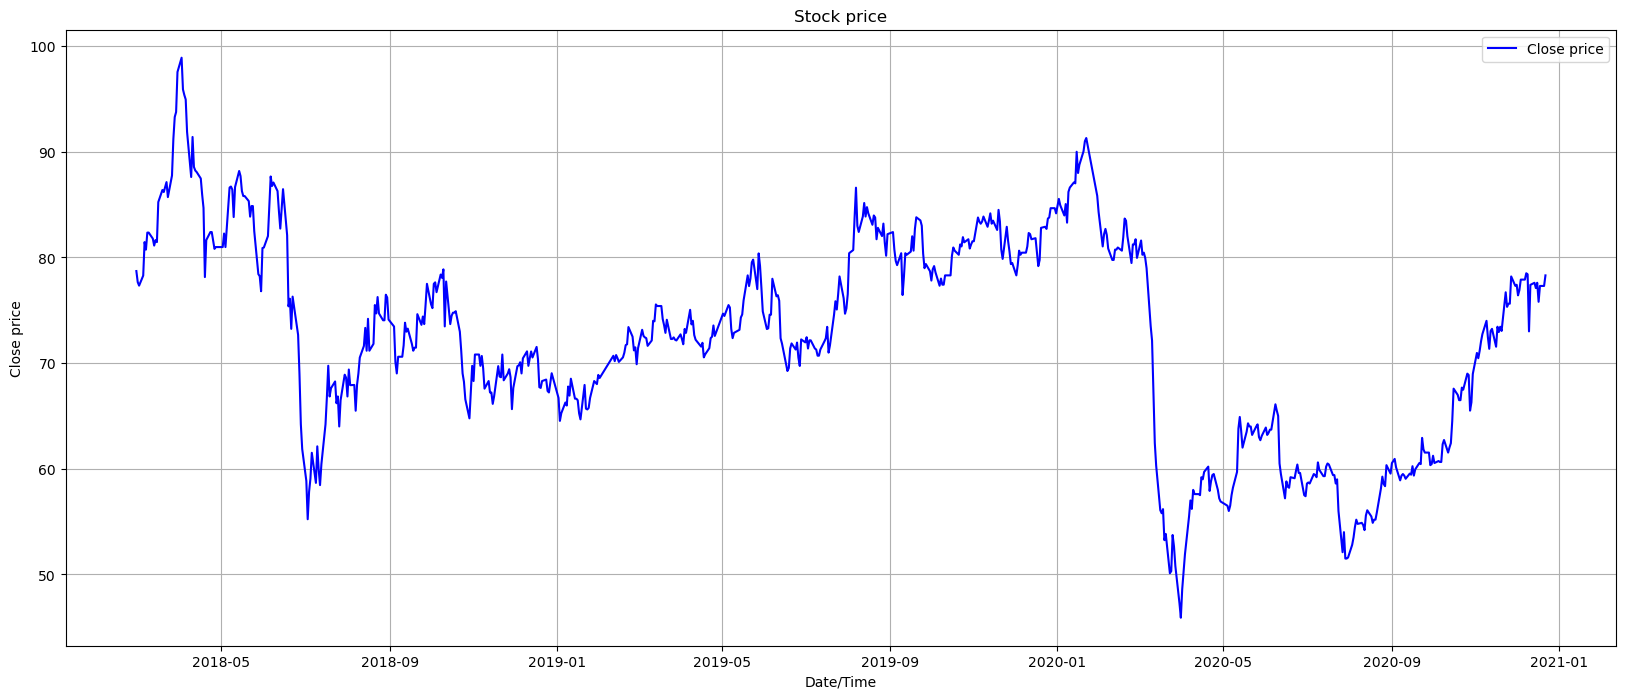

In [29]:
plt.figure(figsize=(20,8))
plt.plot(data['Date/Time'], data['Close'], label='Close price', color='blue')
plt.xlabel('Date/Time')
plt.ylabel('Close price')
plt.title('Stock price')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# feature 
data['Price_fluctuation'] = data['Close'].shift(-1) - data['Close'] 
price_fluctuation = data['Price_fluctuation'].shift(1)

features = ['Open', 'High', 'Low', 'Volume']
X = data[features]
y = data['Close']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_pred = rf_pred.reshape(-1,1)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
print("Random Forest MSE:", rf_mse)
print("Random Forest MAE:", rf_mae)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_pred = lr_pred.reshape(-1,1)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_mae = mean_absolute_error(y_test, lr_pred)
print("Linear Regression MSE:", lr_mse)
print("Linear Regression MAE:", lr_mae)

# Support Vector Regression - SVR
svr_model = SVR()
svr_model.fit(X_train, y_train)
svr_pred = svr_model.predict(X_test)
svr_pred = svr_pred.reshape(-1,1)
svr_mse = mean_squared_error(y_test, svr_pred)
svr_mae = mean_absolute_error(y_test, svr_pred)
print("Support Vector Regression MSE:", svr_mse)
print("Support Vector Regression MAE:", svr_mae)

# LSTM
X_train_lstm = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_train_lstm, y_train, epochs=500, batch_size=32, verbose=2)
lstm_pred = lstm_model.predict(X_test_lstm)
lstm_pred = lstm_pred.reshape(-1,1)
lstm_mse = mean_squared_error(y_test, lstm_pred)
lstm_mae = mean_absolute_error(y_test, lstm_pred)
print("LSTM MSE:", lstm_mse)
print("LSTM MAE:", lstm_mae)


Random Forest MSE: 1.256730417253528
Random Forest MAE: 0.8463753521126779
Linear Regression MSE: 0.8256819745080285
Linear Regression MAE: 0.7322133547117567
Support Vector Regression MSE: 2.258188008923784
Support Vector Regression MAE: 0.9891303848619285
Epoch 1/500
18/18 - 4s - loss: 5302.6157 - 4s/epoch - 221ms/step
Epoch 2/500
18/18 - 0s - loss: 5227.7212 - 83ms/epoch - 5ms/step
Epoch 3/500
18/18 - 0s - loss: 5013.0693 - 80ms/epoch - 4ms/step
Epoch 4/500
18/18 - 0s - loss: 4446.2251 - 76ms/epoch - 4ms/step
Epoch 5/500
18/18 - 0s - loss: 3811.3369 - 75ms/epoch - 4ms/step
Epoch 6/500
18/18 - 0s - loss: 3465.0303 - 74ms/epoch - 4ms/step
Epoch 7/500
18/18 - 0s - loss: 3263.9961 - 75ms/epoch - 4ms/step
Epoch 8/500
18/18 - 0s - loss: 3107.5103 - 76ms/epoch - 4ms/step
Epoch 9/500
18/18 - 0s - loss: 2971.1633 - 75ms/epoch - 4ms/step
Epoch 10/500
18/18 - 0s - loss: 2846.9365 - 76ms/epoch - 4ms/step
Epoch 11/500
18/18 - 0s - loss: 2731.8643 - 75ms/epoch - 4ms/step
Epoch 12/500
18/18 - 0s -

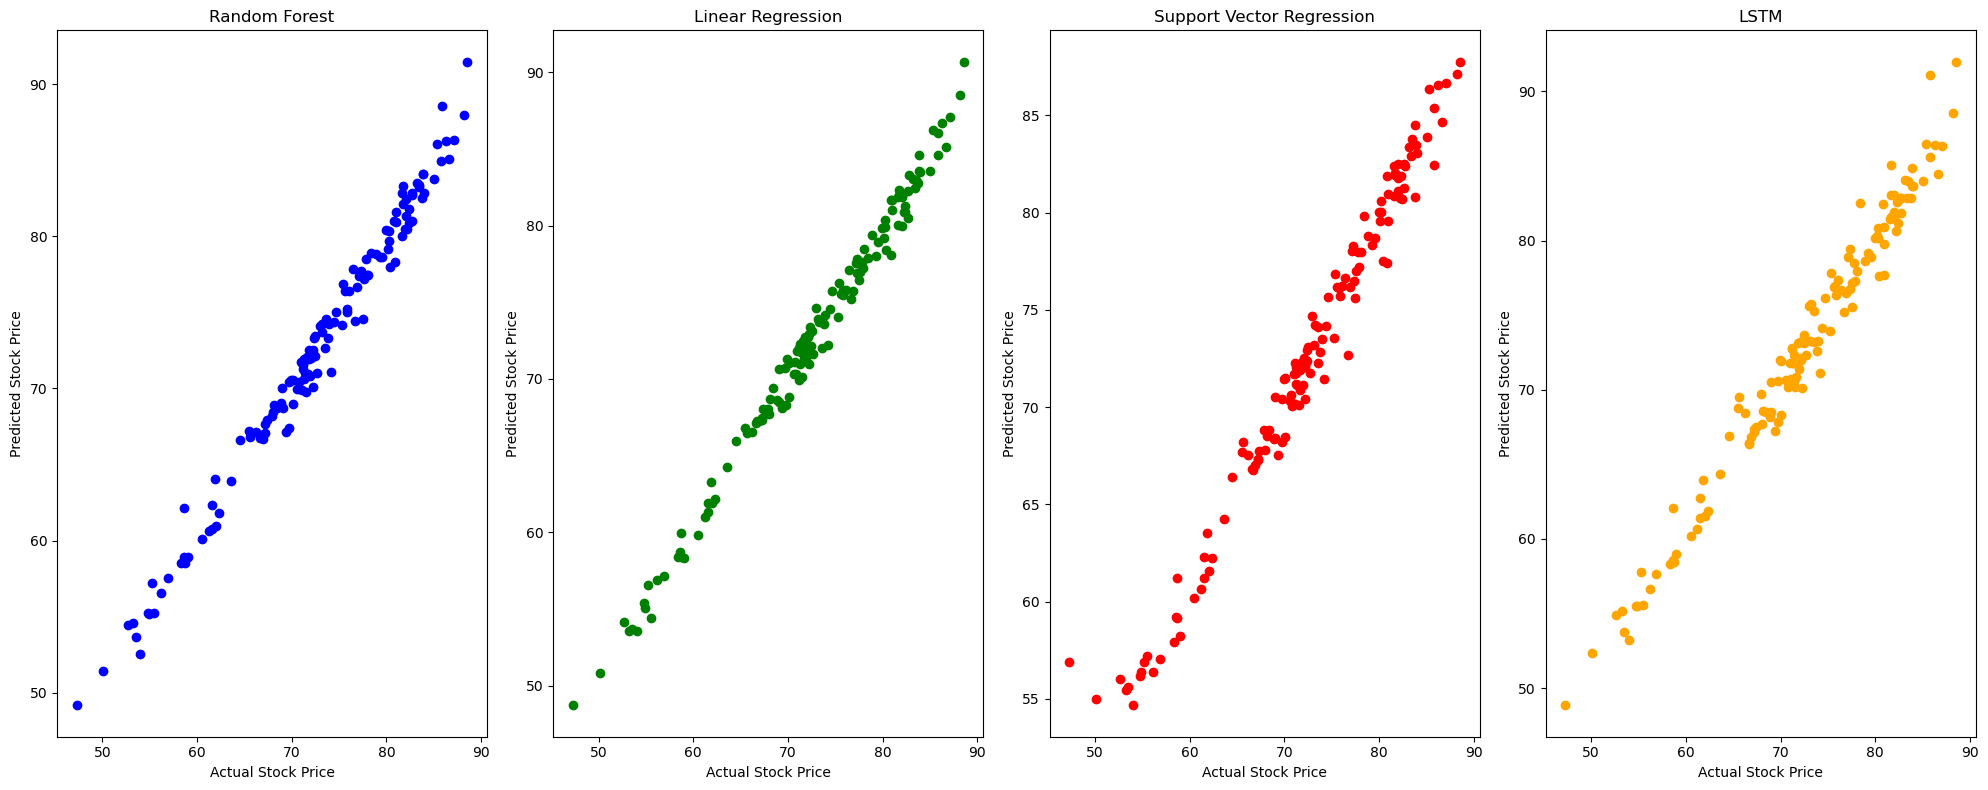

In [32]:
# visualize results
models = ['Random Forest', 'Linear Regression', 'Support Vector Regression', 'LSTM']
result_predictions = [rf_pred, lr_pred, svr_pred, lstm_pred]
colors = ['blue', 'green', 'red', 'orange']

plt.figure(figsize=(20, 8))
for i, (model, result_pred, color) in enumerate(zip(models, result_predictions, colors), 1): 
    plt.subplot(1, 4, i)
    plt.scatter(y_test, result_pred, color=color)
    plt.title(model)
    plt.xlabel('Actual Stock Price')
    plt.ylabel('Predicted Stock Price')
plt.tight_layout()
plt.show()


In [33]:
X_lstm = np.array(X).reshape((X.shape[0], X.shape[1], 1))

rf_prediction = rf_model.predict(X).reshape(-1)  
lr_prediction = lr_model.predict(X).reshape(-1)  
svr_prediction = svr_model.predict(X).reshape(-1)  
lstm_prediction = lstm_model.predict(X_lstm).reshape(-1)  

# add predictions to DataFrame
data['Close_rf_pred'] = rf_prediction
data['Close_lr_pred'] = lr_prediction
data['Close_svr_pred'] = svr_prediction
data['Close_lstm_pred'] = lstm_prediction

# calculate price fluctuation predictions
data['Price_flu_rf_pred'] = data['Close_rf_pred'].shift(-1) - data['Close_rf_pred']
price_flu_rf_pred = data['Price_flu_rf_pred'].shift(1) 
data['Price_flu_lr_pred'] = data['Close_lr_pred'].shift(-1) - data['Close_lr_pred'] 
price_flu_lr_pred = data['Price_flu_lr_pred'].shift(1)
data['Price_flu_svr_pred'] = data['Close_svr_pred'].shift(-1) - data['Close_svr_pred'] 
price_flu_svr_pred = data['Price_flu_svr_pred'].shift(1)
data['Price_flu_lstm_pred'] = data['Close_lstm_pred'].shift(-1) - data['Close_lstm_pred']
price_flu_lstm_pred = data['Price_flu_lstm_pred'].shift(1)

# compare dataframe
compare = pd.DataFrame({
    'Date/Time': data['Date/Time'],
    'Close price test': y,
    'Close price change': price_fluctuation,
    'Close rf pred': rf_prediction,
    'Price change rf pred': price_flu_rf_pred,
    'Close lr pred': lr_prediction,
    'Price change lr pred': price_flu_lr_pred,
    'Close svr pred': svr_prediction,
    'Price change svr pred': price_flu_svr_pred,    
    'Close lstm pred': lstm_prediction,
    'Price change lstm pred': price_flu_lstm_pred
})
compare


23/23 [==============================] - 0s 3ms/step


Date/Time  Close price test  Close price change  Close rf pred  \
0   2018-02-28             78.71                 NaN        78.9038   
1   2018-03-01             77.66               -1.05        77.8950   
2   2018-03-02             77.33               -0.33        77.5455   
3   2018-03-05             78.28                0.95        78.6741   
4   2018-03-06             81.45                3.17        80.7074   
..         ...               ...                 ...            ...   
704 2020-12-16             77.60                0.50        77.1834   
705 2020-12-17             75.80               -1.80        75.2431   
706 2020-12-18             77.30                1.50        77.1859   
707 2020-12-21             77.30                0.00        77.1170   
708 2020-12-22             78.30                1.00        77.9503   

     Price change rf pred  Close lr pred  Price change lr pred  \
0                     NaN      79.138561                   NaN   
1                 -1.0088      78.631150             -0.507410   
2                 -0.3495      76.899974             -1.731177   
3                  1.1286      78.773645              1.873671   
4                  2.0333      80.065681              1.292036   
..                    ...            ...                   ...   
704                0.0330      76.975280             -0.069606   
705               -1.9403      75.829424             -1.145856   
706                1.9428      76.572224              0.742800   
707               -0.0689      76.439256             -0.132969   
708                0.8333      77.570102              1.130847   

     Close svr pred  Price change svr pred  Close lstm pred  \
0         78.325964                    NaN        78.436722   
1         78.023558              -0.302405        78.298714   
2         76.493408              -1.530150        76.780312   
3         77.703659               1.210251        77.725357   
4         79.145308               1.441649        79.542557   
..              ...                    ...              ...   
704       76.996450              -0.489936        77.144905   
705       76.110857              -0.885593        76.931557   
706       76.208513               0.097656        76.135880   
707       76.713948               0.505435        77.111061   
708       77.736771               1.022823        78.070892   

     Price change lstm pred  
0                       NaN  
1                 -0.138008  
2                 -1.518402  
3                  0.945045  
4                  1.817200  
..                      ...  
704               -1.005157  
705               -0.213348  
706               -0.795677  
707                0.975182  
708                0.959831  

[709 rows x 11 columns]

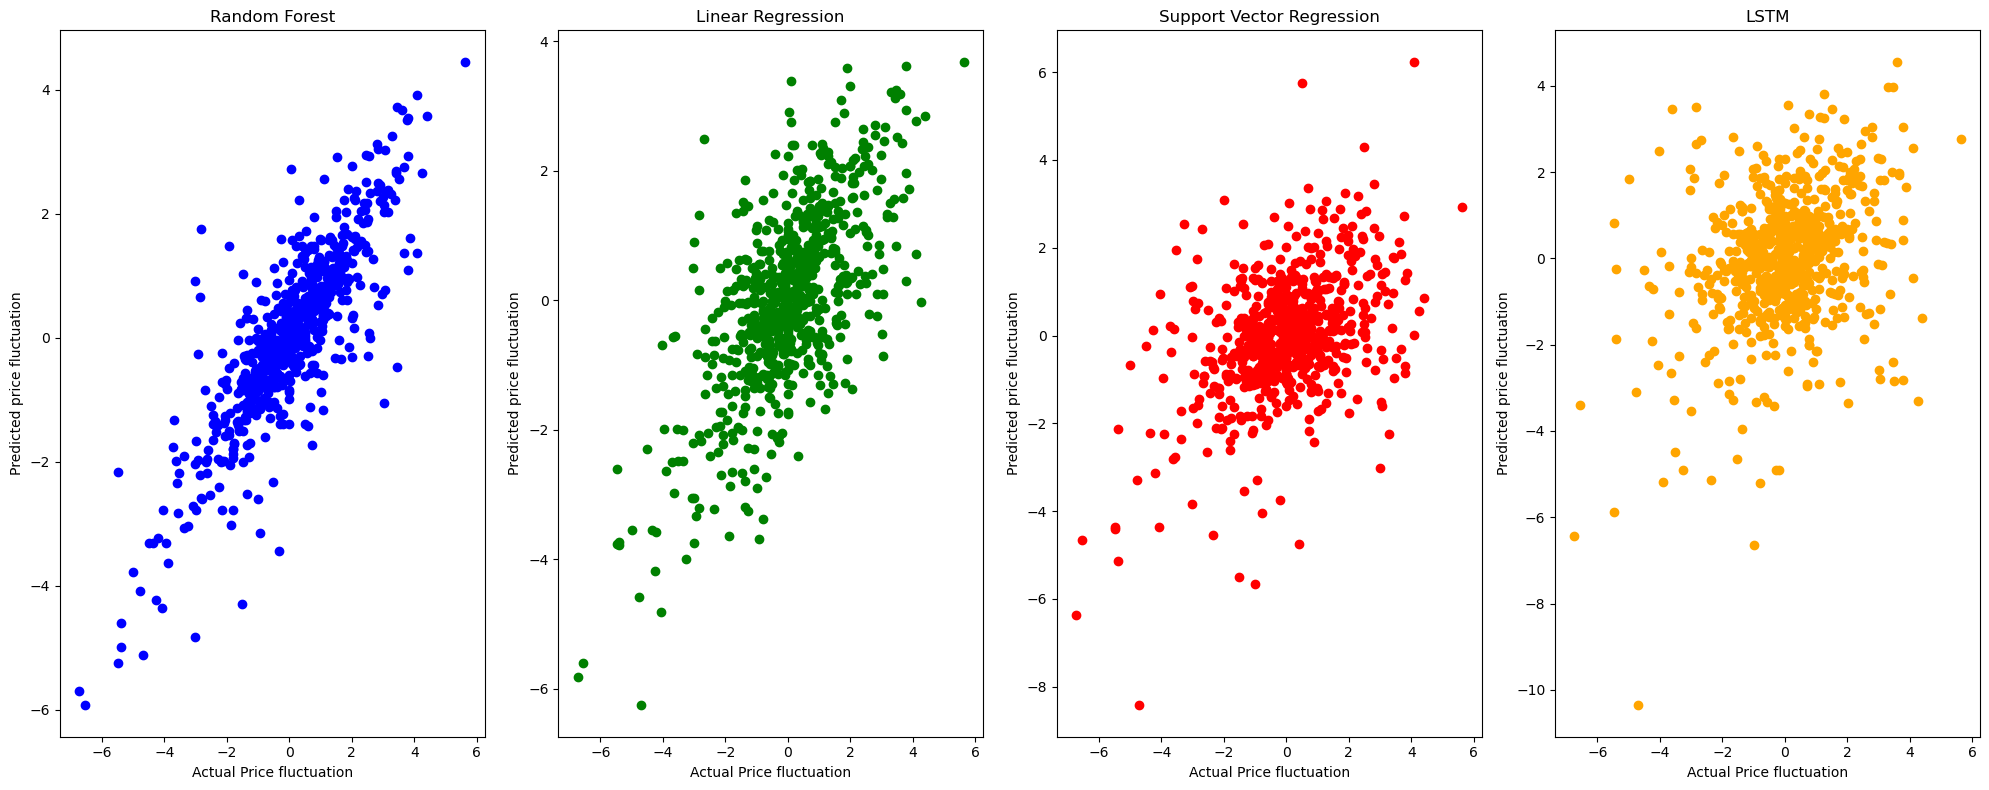

In [34]:
# visualize results

models = ['Random Forest', 'Linear Regression', 'Support Vector Regression', 'LSTM']
price_flu_predictions = ['Price_flu_rf_pred', 'Price_flu_lr_pred', 'Price_flu_svr_pred', 'Price_flu_lstm_pred']
colors = ['blue', 'green', 'red', 'orange']

plt.figure(figsize=(20, 8))
for i, (model, price_flu_pre, color) in enumerate(zip(models, price_flu_predictions, colors), 1):

    plt.subplot(1, 4, i)
    plt.scatter(data['Price_fluctuation'], data[price_flu_pre], color=color)
    plt.title(model)
    plt.xlabel('Actual Price fluctuation')
    plt.ylabel('Predicted price fluctuation')
plt.tight_layout()
plt.show()

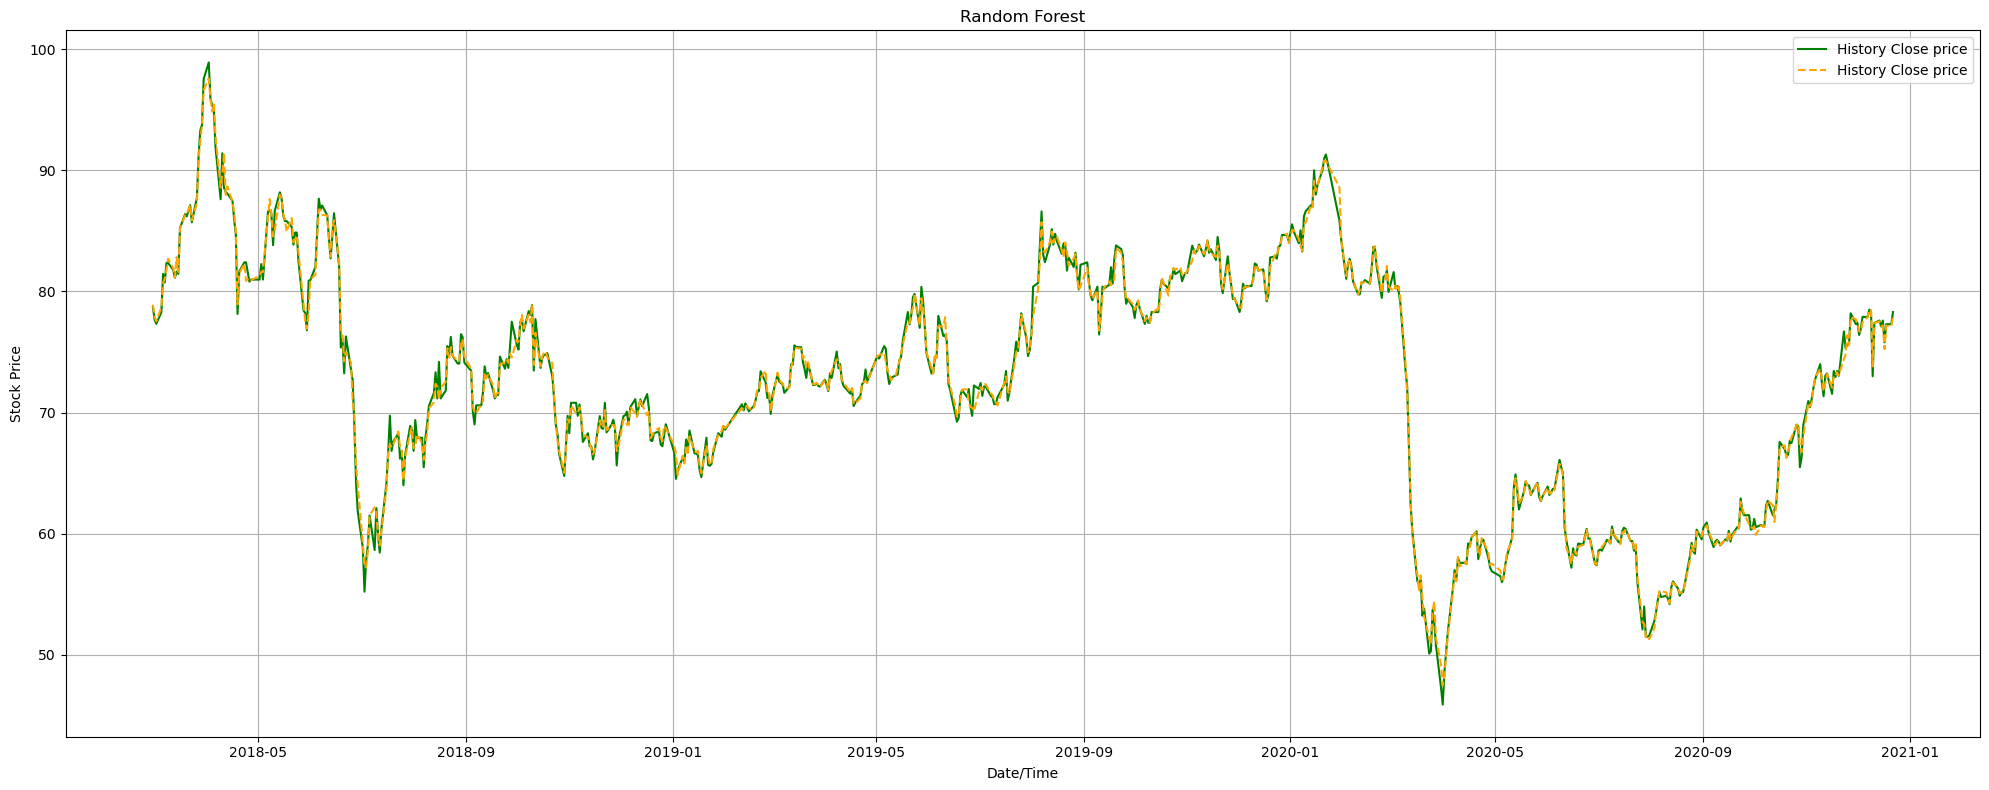

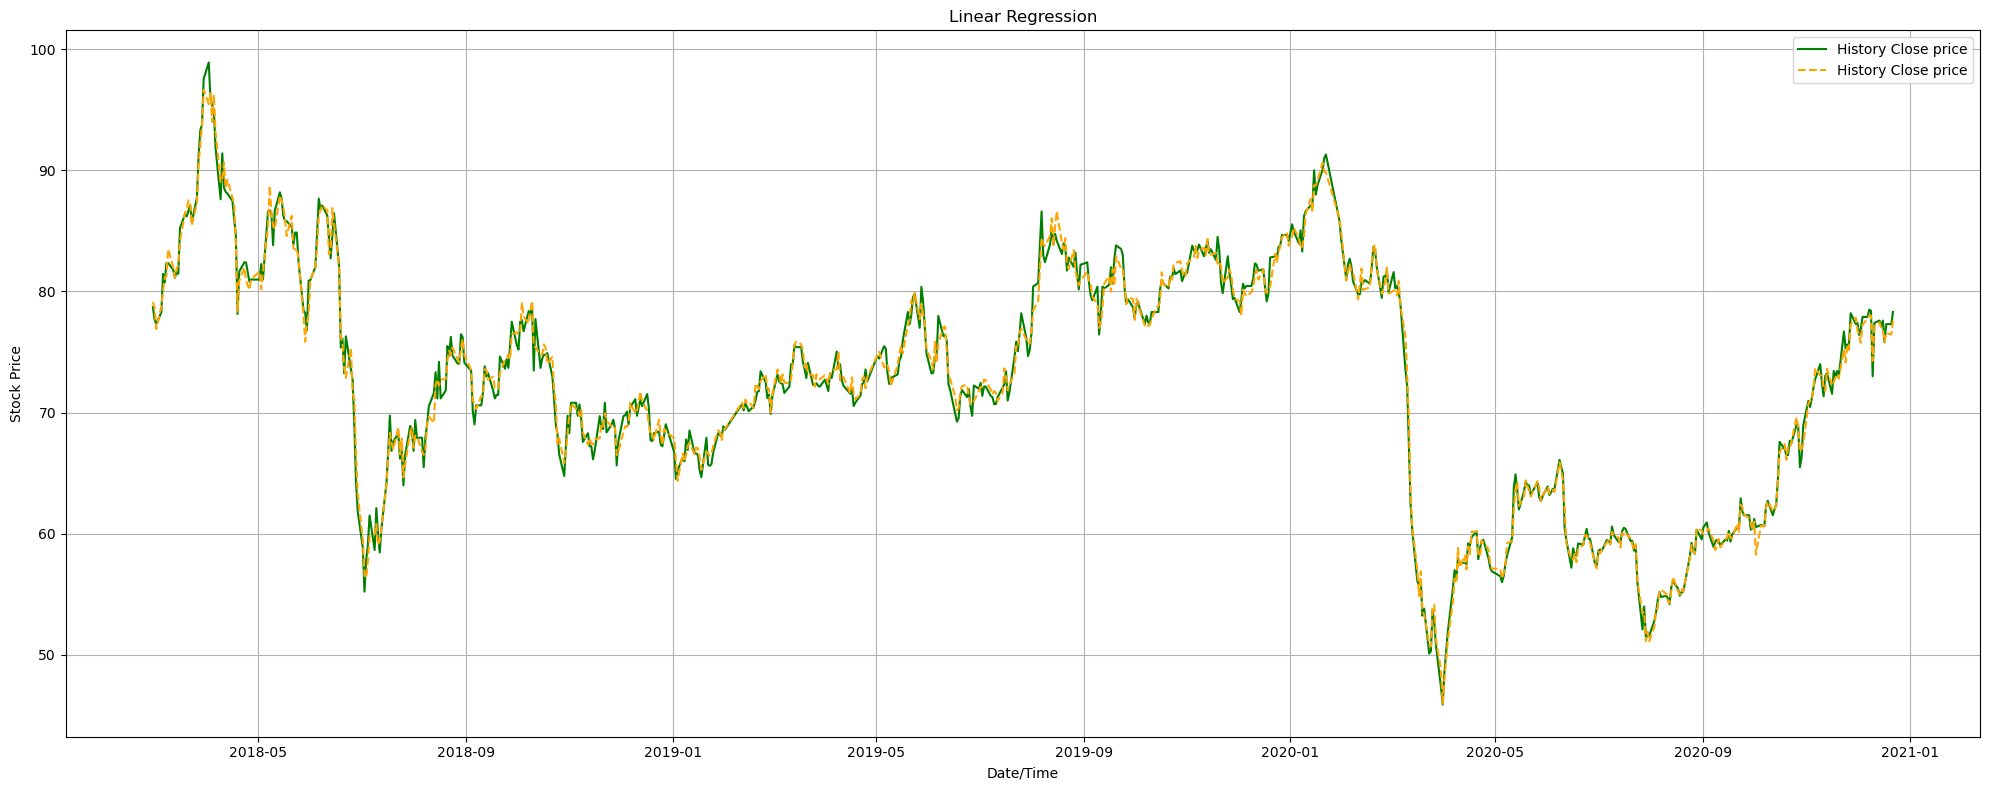

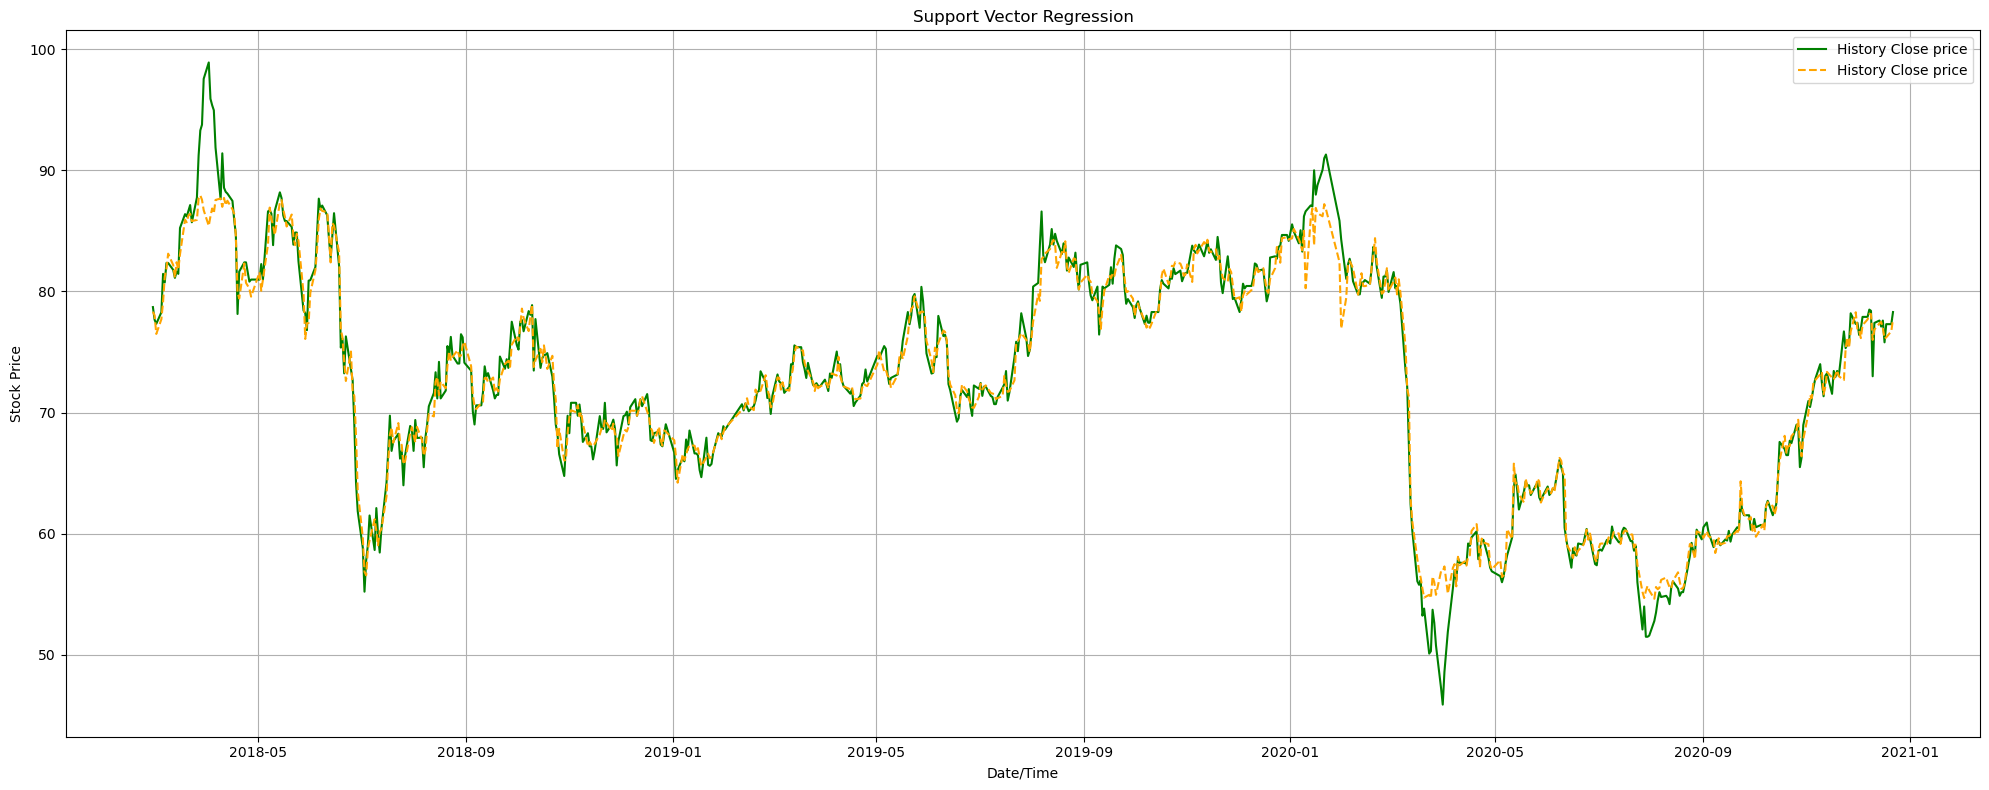

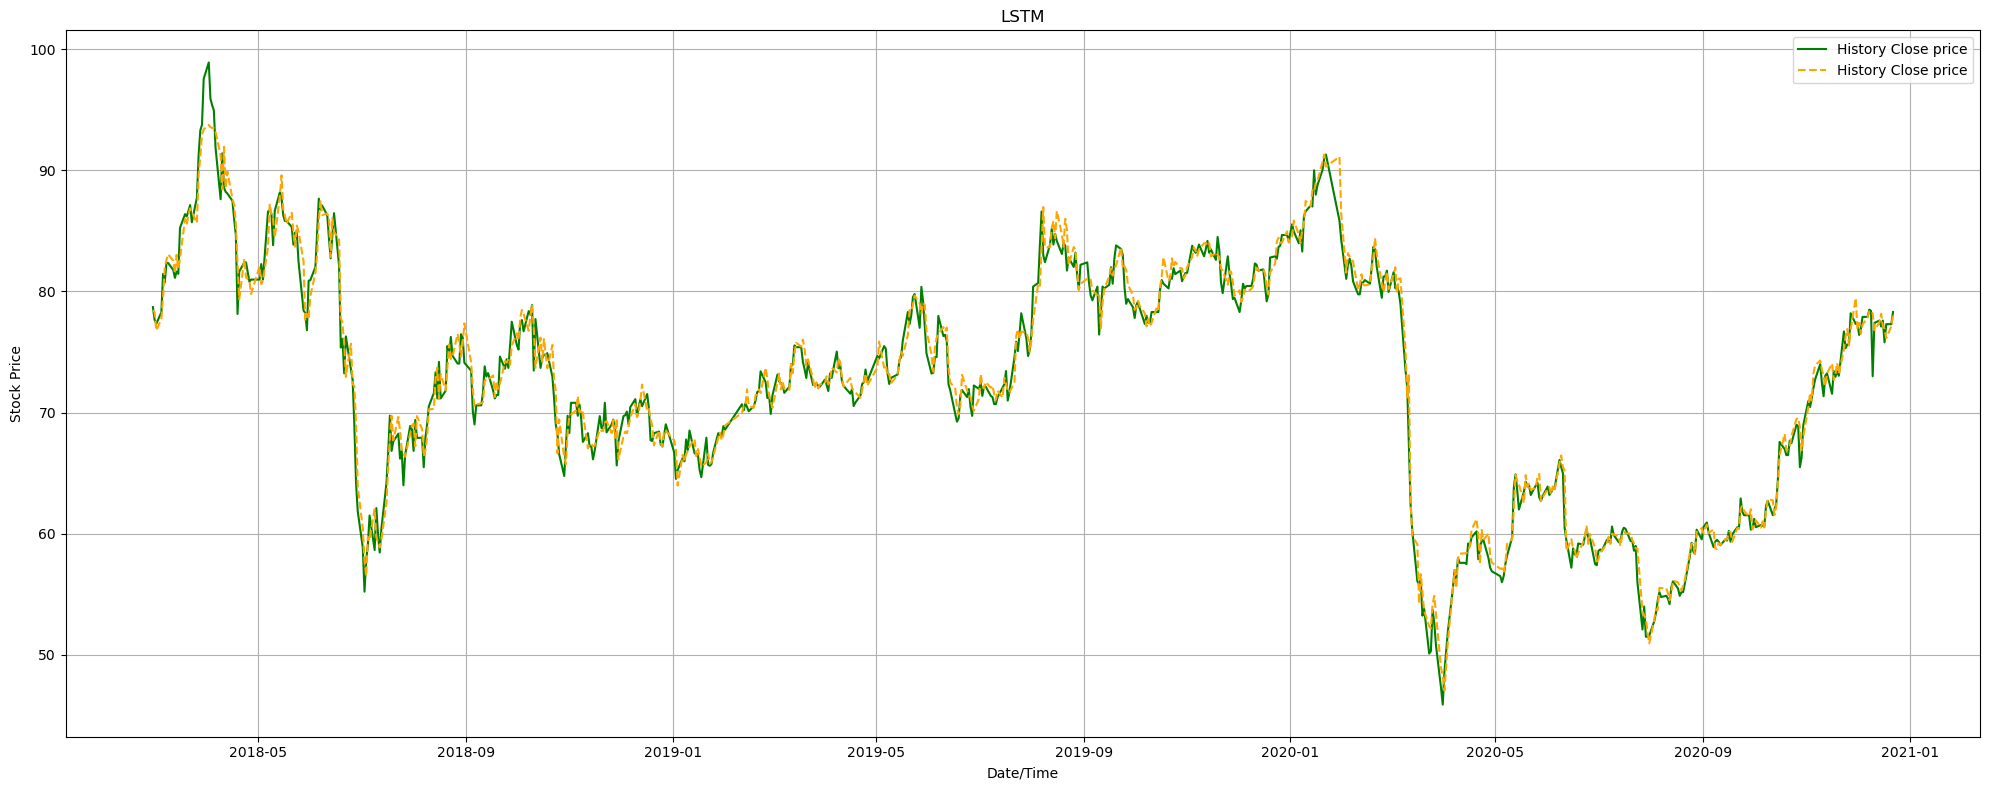

In [35]:
# visualize results

models = ['Random Forest', 'Linear Regression', 'Support Vector Regression', 'LSTM']
close_predictions = ['Close_rf_pred', 'Close_lr_pred', 'Close_svr_pred', 'Close_lstm_pred']

for model, close_pre in zip(models, close_predictions):
    plt.figure(figsize=(20, 8))
    plt.plot(data['Date/Time'], data['Close'], label='History Close price', color='green')
    plt.plot(data['Date/Time'], data[close_pre], label='History Close price', color='orange', linestyle='dashed')
    plt.title(model)
    plt.xlabel('Date/Time')
    plt.ylabel('Stock Price')
    plt.tight_layout()
    plt.legend()
    plt.grid(True)
    plt.show()


## FPT Stock

In [36]:
# load data
df = pd.read_csv('FPT.csv')
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df['Date/Time'] = df['Date/Time'].dt.floor('D') #change to minute(min) hour(h) or day(d)

# groupby 'Date/Time' 
data = df.groupby(['Ticker', pd.Grouper(key='Date/Time')]).agg({
    'Open': 'first',   
    'High': 'max',     
    'Low': 'min',     
    'Close': 'last',   
    'Volume': 'sum',  
    'Open Interest': 'sum' 
}).reset_index()

data

Ticker  Date/Time   Open   High    Low  Close   Volume  Open Interest
0      FPT 2018-12-25  30.89  30.89  30.59  30.66    84960              0
1      FPT 2018-12-26  31.04  31.22  30.89  30.89   333590              0
2      FPT 2018-12-27  31.41  31.52  31.19  31.19   454860              0
3      FPT 2018-12-28  31.34  31.49  31.19  31.49   387170              0
4      FPT 2019-01-02  31.19  31.45  30.70  30.74   459120              0
..     ...        ...    ...    ...    ...    ...      ...            ...
494    FPT 2020-12-16  57.20  57.50  57.00  57.10  1995530              0
495    FPT 2020-12-17  56.90  57.00  56.00  56.50  3594500              0
496    FPT 2020-12-18  56.50  57.00  56.50  56.90  1532820              0
497    FPT 2020-12-21  57.30  57.80  57.10  57.50  2307390              0
498    FPT 2020-12-22  57.40  58.50  57.20  58.10  2576390              0

[499 rows x 8 columns]

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Ticker         499 non-null    object        
 1   Date/Time      499 non-null    datetime64[ns]
 2   Open           499 non-null    float64       
 3   High           499 non-null    float64       
 4   Low            499 non-null    float64       
 5   Close          499 non-null    float64       
 6   Volume         499 non-null    int64         
 7   Open Interest  499 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 31.3+ KB


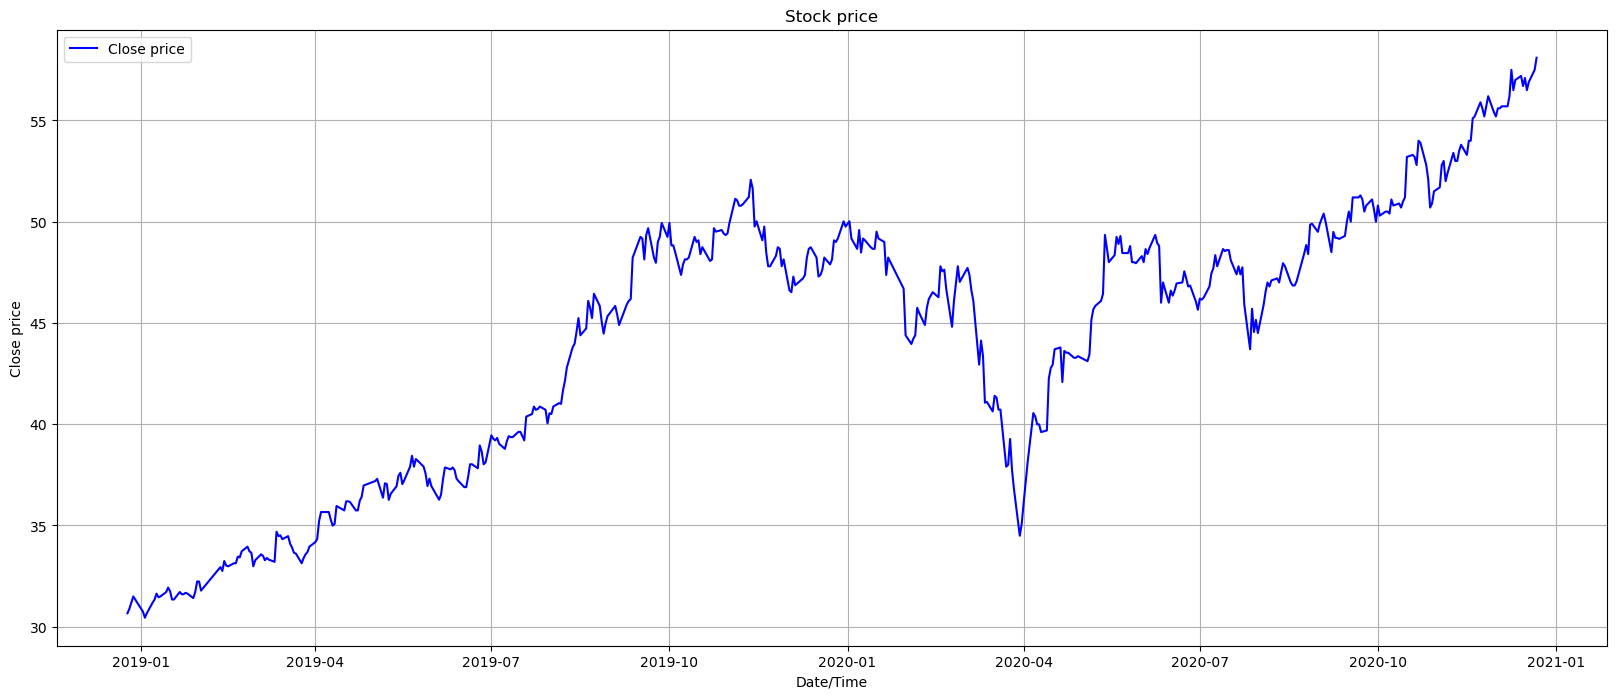

In [38]:
plt.figure(figsize=(20,8))
plt.plot(data['Date/Time'], data['Close'], label='Close price', color='blue')
plt.xlabel('Date/Time')
plt.ylabel('Close price')
plt.title('Stock price')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# feature 
data['Price_fluctuation'] = data['Close'].shift(-1) - data['Close'] 
price_fluctuation = data['Price_fluctuation'].shift(1)

features = ['Open', 'High', 'Low', 'Volume']
X = data[features]
y = data['Close']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_pred = rf_pred.reshape(-1,1)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
print("Random Forest MSE:", rf_mse)
print("Random Forest MAE:", rf_mae)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_pred = lr_pred.reshape(-1,1)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_mae = mean_absolute_error(y_test, lr_pred)
print("Linear Regression MSE:", lr_mse)
print("Linear Regression MAE:", lr_mae)

# Support Vector Regression - SVR
svr_model = SVR()
svr_model.fit(X_train, y_train)
svr_pred = svr_model.predict(X_test)
svr_pred = svr_pred.reshape(-1,1)
svr_mse = mean_squared_error(y_test, svr_pred)
svr_mae = mean_absolute_error(y_test, svr_pred)
print("Support Vector Regression MSE:", svr_mse)
print("Support Vector Regression MAE:", svr_mae)

# LSTM
X_train_lstm = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_train_lstm, y_train, epochs=500, batch_size=32, verbose=2)
lstm_pred = lstm_model.predict(X_test_lstm)
lstm_pred = lstm_pred.reshape(-1,1)
lstm_mse = mean_squared_error(y_test, lstm_pred)
lstm_mae = mean_absolute_error(y_test, lstm_pred)
print("LSTM MSE:", lstm_mse)
print("LSTM MAE:", lstm_mae)


Random Forest MSE: 0.1271921795999997
Random Forest MAE: 0.2694540000000019
Linear Regression MSE: 0.07968709360007663
Linear Regression MAE: 0.21518568456672788
Support Vector Regression MSE: 0.3914915359761727
Support Vector Regression MAE: 0.4121066071152421
Epoch 1/500
13/13 - 5s - loss: 1998.6366 - 5s/epoch - 368ms/step
Epoch 2/500
13/13 - 0s - loss: 1972.5609 - 87ms/epoch - 7ms/step
Epoch 3/500
13/13 - 0s - loss: 1926.2091 - 75ms/epoch - 6ms/step
Epoch 4/500
13/13 - 0s - loss: 1824.5908 - 58ms/epoch - 4ms/step
Epoch 5/500
13/13 - 0s - loss: 1611.3640 - 55ms/epoch - 4ms/step
Epoch 6/500
13/13 - 0s - loss: 1322.7714 - 72ms/epoch - 6ms/step
Epoch 7/500
13/13 - 0s - loss: 1096.6365 - 76ms/epoch - 6ms/step
Epoch 8/500
13/13 - 0s - loss: 966.2429 - 64ms/epoch - 5ms/step
Epoch 9/500
13/13 - 0s - loss: 884.0243 - 54ms/epoch - 4ms/step
Epoch 10/500
13/13 - 0s - loss: 821.4613 - 52ms/epoch - 4ms/step
Epoch 11/500
13/13 - 0s - loss: 768.9498 - 52ms/epoch - 4ms/step
Epoch 12/500
13/13 - 0s -

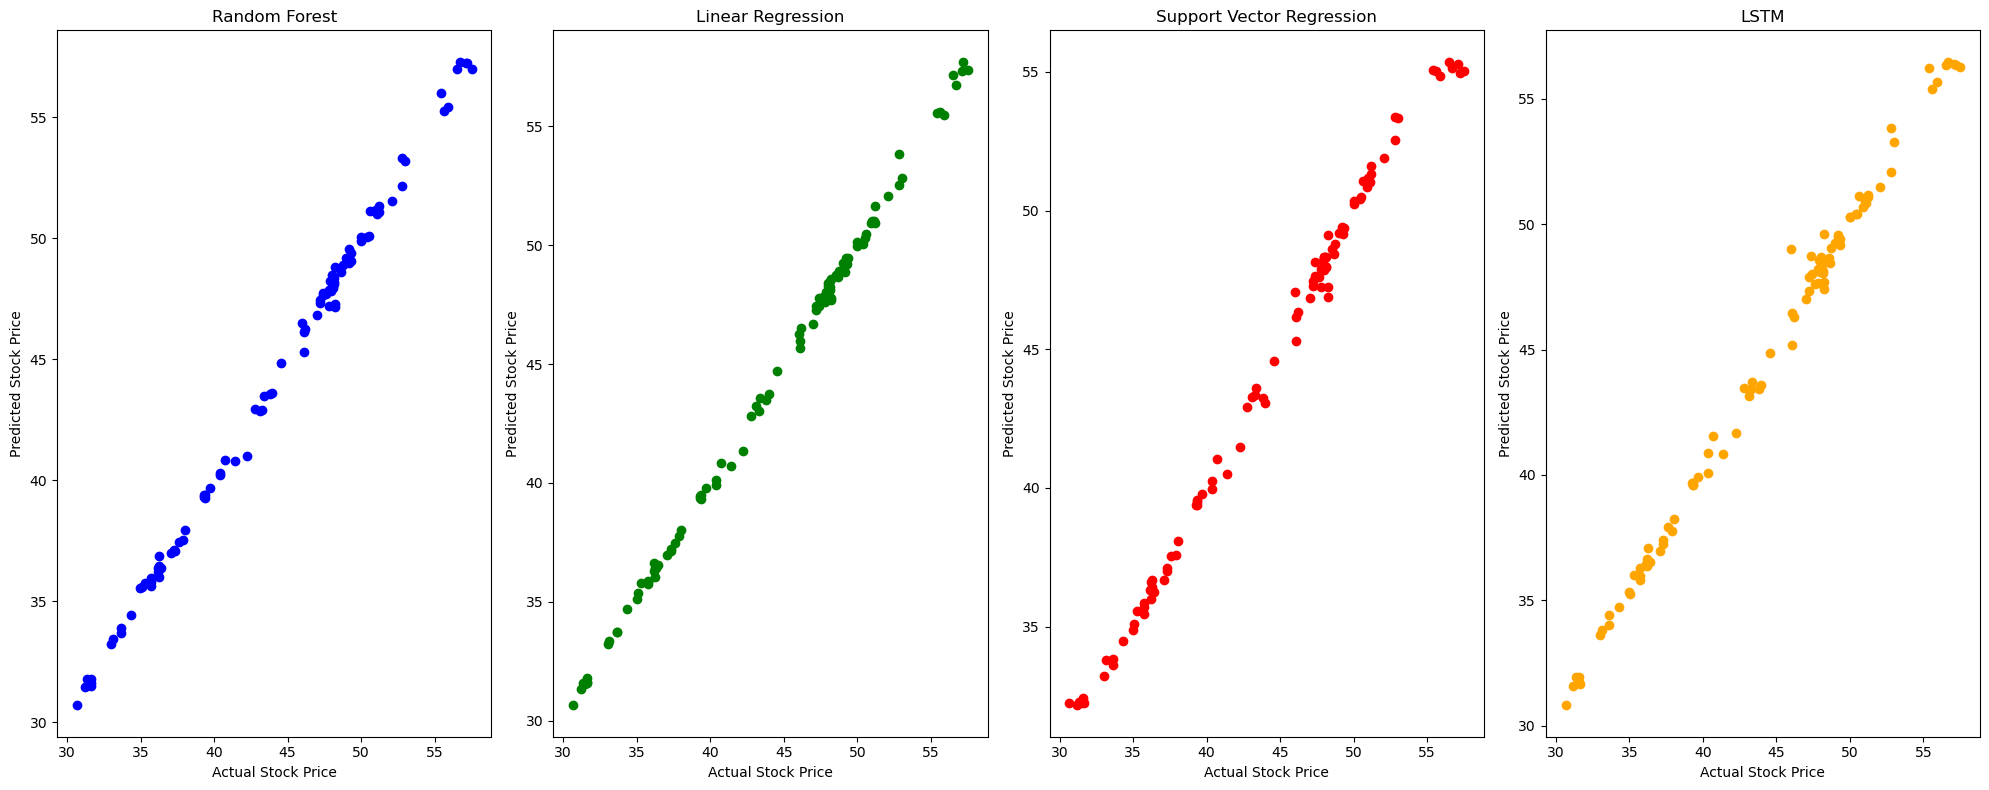

In [41]:
# visualize results
models = ['Random Forest', 'Linear Regression', 'Support Vector Regression', 'LSTM']
result_predictions = [rf_pred, lr_pred, svr_pred, lstm_pred]
colors = ['blue', 'green', 'red', 'orange']

plt.figure(figsize=(20, 8))
for i, (model, result_pred, color) in enumerate(zip(models, result_predictions, colors), 1): 
    plt.subplot(1, 4, i)
    plt.scatter(y_test, result_pred, color=color)
    plt.title(model)
    plt.xlabel('Actual Stock Price')
    plt.ylabel('Predicted Stock Price')
plt.tight_layout()
plt.show()


In [42]:
X_lstm = np.array(X).reshape((X.shape[0], X.shape[1], 1))

rf_prediction = rf_model.predict(X).reshape(-1)  
lr_prediction = lr_model.predict(X).reshape(-1)  
svr_prediction = svr_model.predict(X).reshape(-1)  
lstm_prediction = lstm_model.predict(X_lstm).reshape(-1)  

# add predictions to DataFrame
data['Close_rf_pred'] = rf_prediction
data['Close_lr_pred'] = lr_prediction
data['Close_svr_pred'] = svr_prediction
data['Close_lstm_pred'] = lstm_prediction

# calculate price fluctuation predictions
data['Price_flu_rf_pred'] = data['Close_rf_pred'].shift(-1) - data['Close_rf_pred']
price_flu_rf_pred = data['Price_flu_rf_pred'].shift(1) 
data['Price_flu_lr_pred'] = data['Close_lr_pred'].shift(-1) - data['Close_lr_pred'] 
price_flu_lr_pred = data['Price_flu_lr_pred'].shift(1)
data['Price_flu_svr_pred'] = data['Close_svr_pred'].shift(-1) - data['Close_svr_pred'] 
price_flu_svr_pred = data['Price_flu_svr_pred'].shift(1)
data['Price_flu_lstm_pred'] = data['Close_lstm_pred'].shift(-1) - data['Close_lstm_pred']
price_flu_lstm_pred = data['Price_flu_lstm_pred'].shift(1)

print('Price Fluctuation')
# compare dataframe
compare = pd.DataFrame({
    'Date/Time': data['Date/Time'],
    'Close price test': y,
    'Close price change': price_fluctuation,
    'Close rf pred': rf_prediction,
    'Price change rf pred': price_flu_rf_pred,
    'Close lr pred': lr_prediction,
    'Price change lr pred': price_flu_lr_pred,
    'Close svr pred': svr_prediction,
    'Price change svr pred': price_flu_svr_pred,    
    'Close lstm pred': lstm_prediction,
    'Price change lstm pred': price_flu_lstm_pred
})
compare


16/16 [==============================] - 0s 2ms/step
Price Fluctuation


Date/Time  Close price test  Close price change  Close rf pred  \
0   2018-12-25             30.66                 NaN        30.7211   
1   2018-12-26             30.89                0.23        31.0211   
2   2018-12-27             31.19                0.30        31.4421   
3   2018-12-28             31.49                0.30        31.4154   
4   2019-01-02             30.74               -0.75        30.9137   
..         ...               ...                 ...            ...   
494 2020-12-16             57.10                0.40        57.2510   
495 2020-12-17             56.50               -0.60        56.6570   
496 2020-12-18             56.90                0.40        56.8120   
497 2020-12-21             57.50                0.60        57.4400   
498 2020-12-22             58.10                0.60        57.7100   

     Price change rf pred  Close lr pred  Price change lr pred  \
0                     NaN      30.669920                   NaN   
1                  0.3000      31.081402              0.411482   
2                  0.4210      31.331610              0.250208   
3                 -0.0267      31.356864              0.025254   
4                 -0.5017      30.990103             -0.366761   
..                    ...            ...                   ...   
494               -0.0220      57.315415              0.576027   
495               -0.5940      56.174749             -1.140666   
496                0.1550      56.964031              0.789282   
497                0.6280      57.557781              0.593749   
498                0.2700      58.113010              0.555230   

     Close svr pred  Price change svr pred  Close lstm pred  \
0         32.228676                    NaN        30.849220   
1         32.143246              -0.085429        31.165491   
2         32.187188               0.043942        31.604259   
3         32.190898               0.003710        31.532133   
4         32.132856              -0.058042        31.359631   
..              ...                    ...              ...   
494       55.290353               0.139286        56.376396   
495       54.227783              -1.062570        56.342110   
496       55.080828               0.853045        56.156906   
497       55.292328               0.211500        56.427132   
498       55.137021              -0.155307        56.491493   

     Price change lstm pred  
0                       NaN  
1                  0.316271  
2                  0.438768  
3                 -0.072126  
4                 -0.172503  
..                      ...  
494               -0.064110  
495               -0.034286  
496               -0.185204  
497                0.270226  
498                0.064362  

[499 rows x 11 columns]

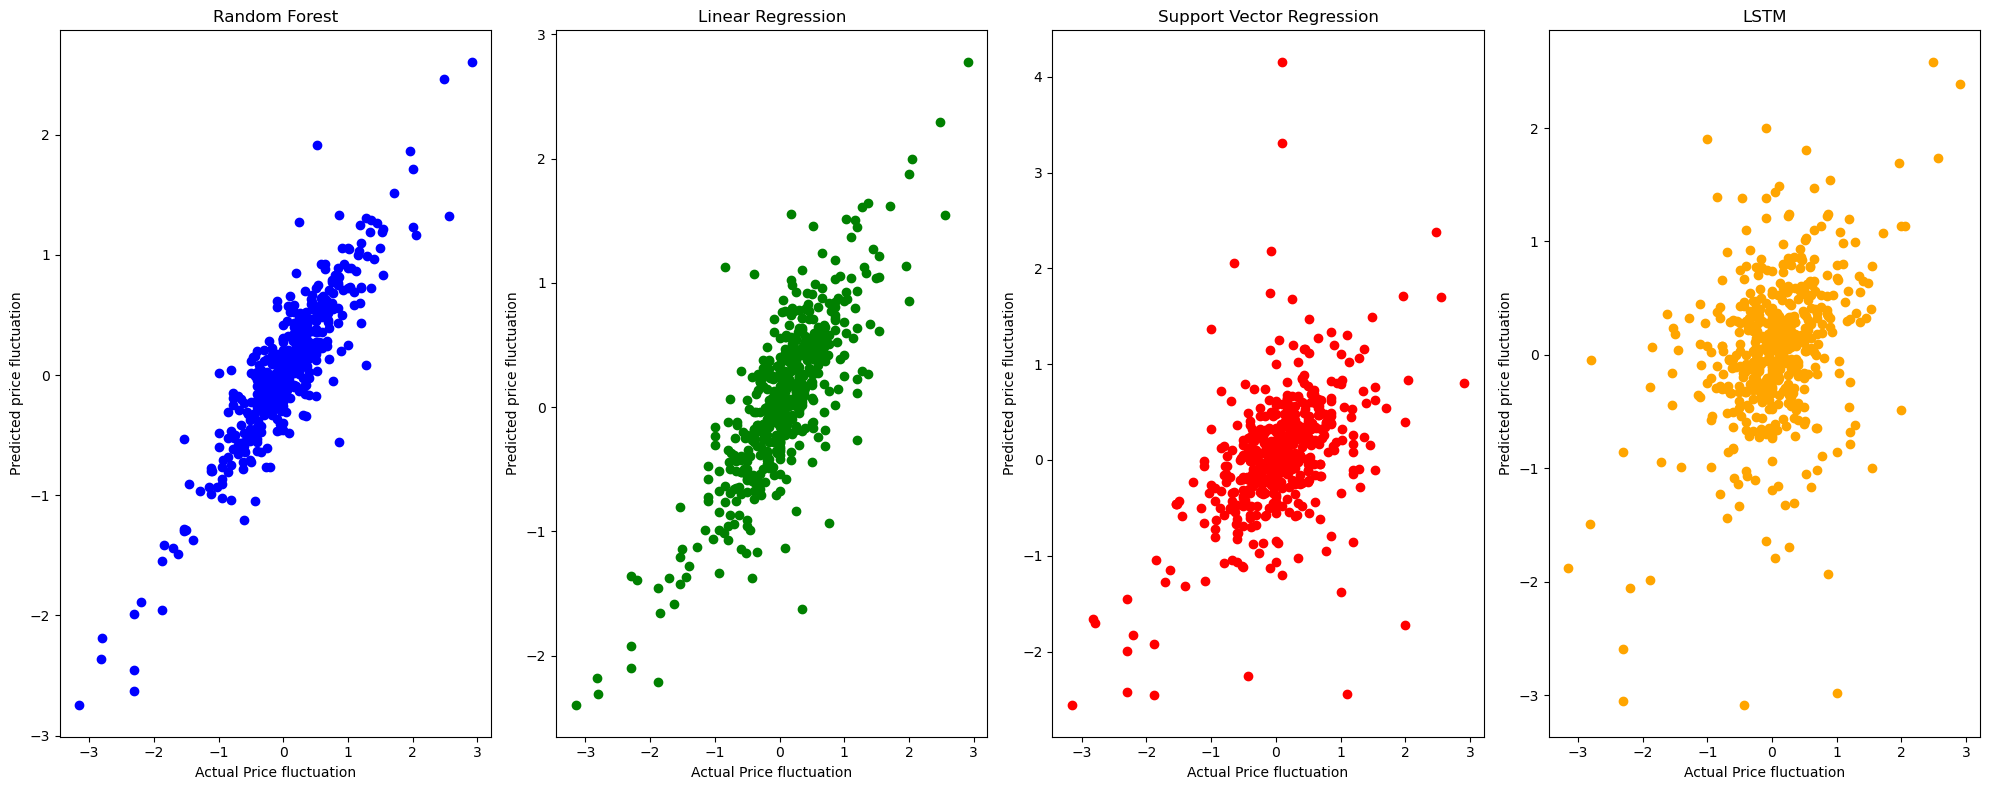

In [43]:
# visualize results

models = ['Random Forest', 'Linear Regression', 'Support Vector Regression', 'LSTM']
price_flu_predictions = ['Price_flu_rf_pred', 'Price_flu_lr_pred', 'Price_flu_svr_pred', 'Price_flu_lstm_pred']
colors = ['blue', 'green', 'red', 'orange']

plt.figure(figsize=(20, 8))
for i, (model, price_flu_pre, color) in enumerate(zip(models, price_flu_predictions, colors), 1):

    plt.subplot(1, 4, i)
    plt.scatter(data['Price_fluctuation'], data[price_flu_pre], color=color)
    plt.title(model)
    plt.xlabel('Actual Price fluctuation')
    plt.ylabel('Predicted price fluctuation')
plt.tight_layout()
plt.show()

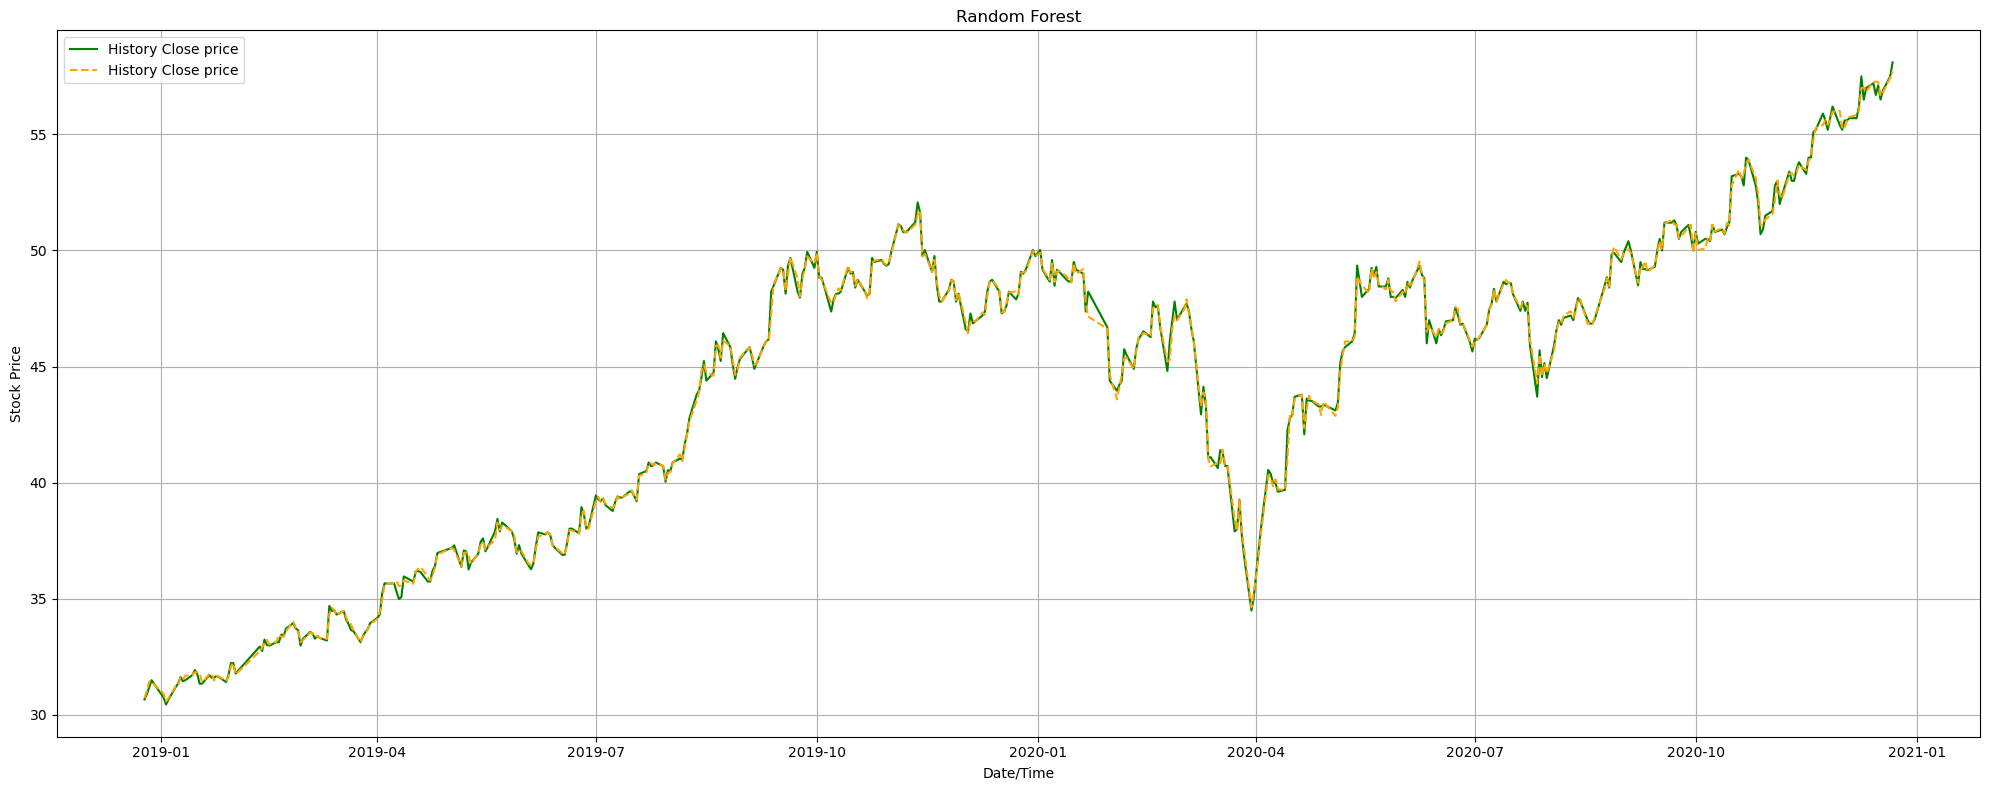

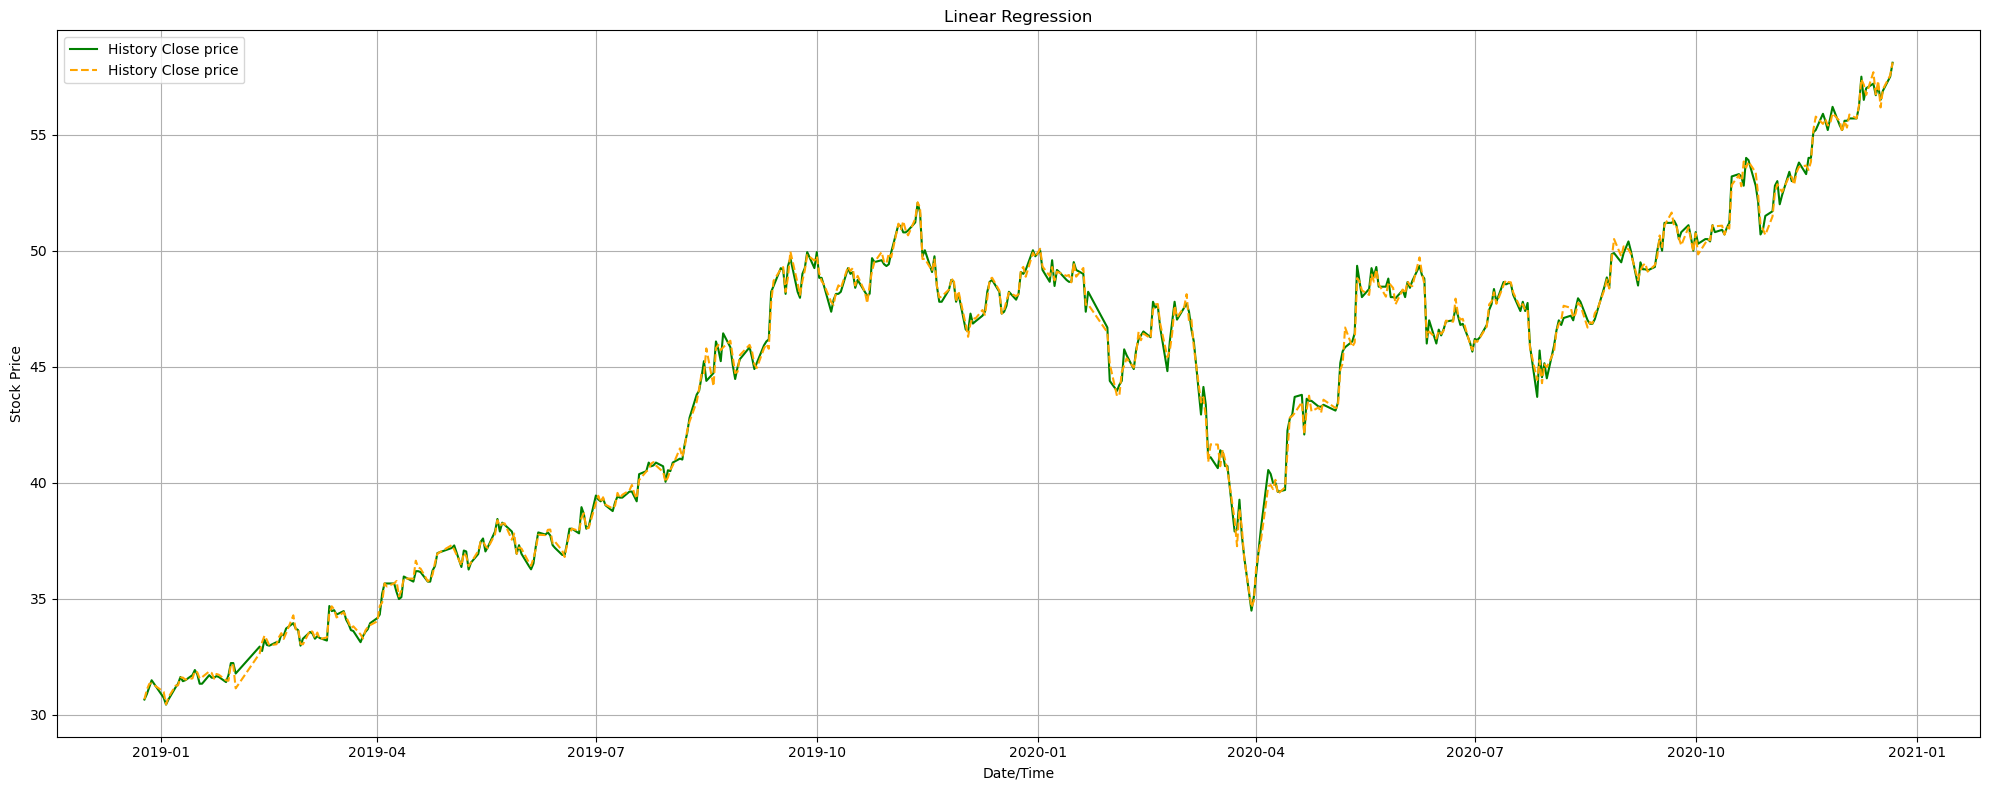

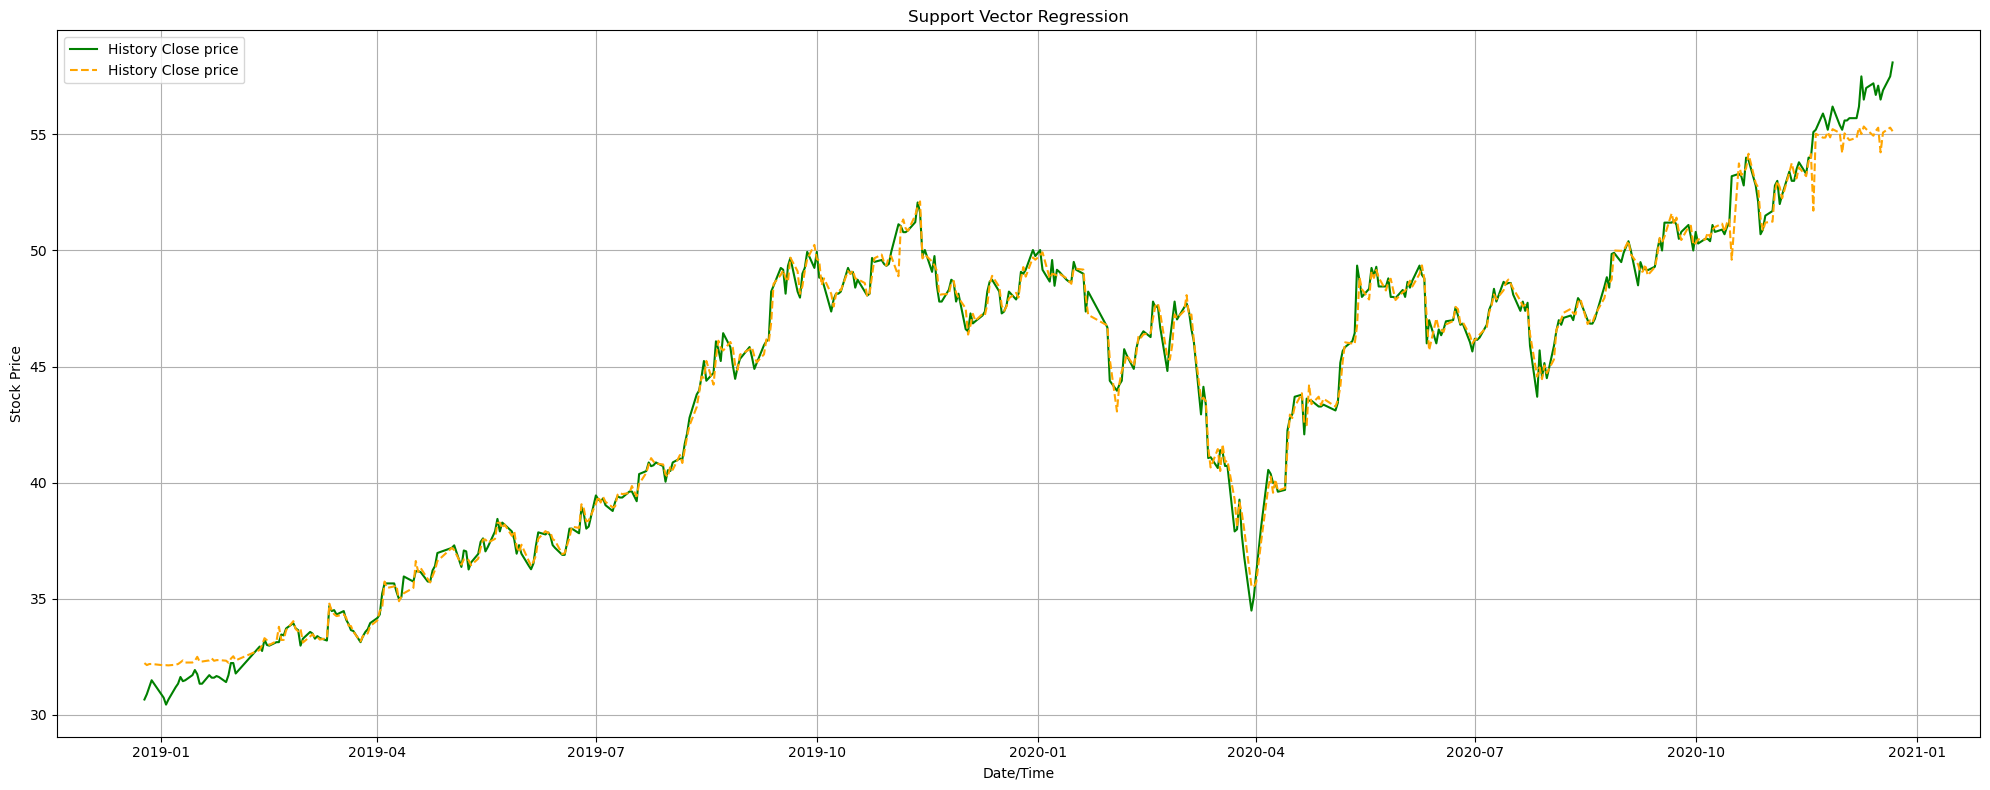

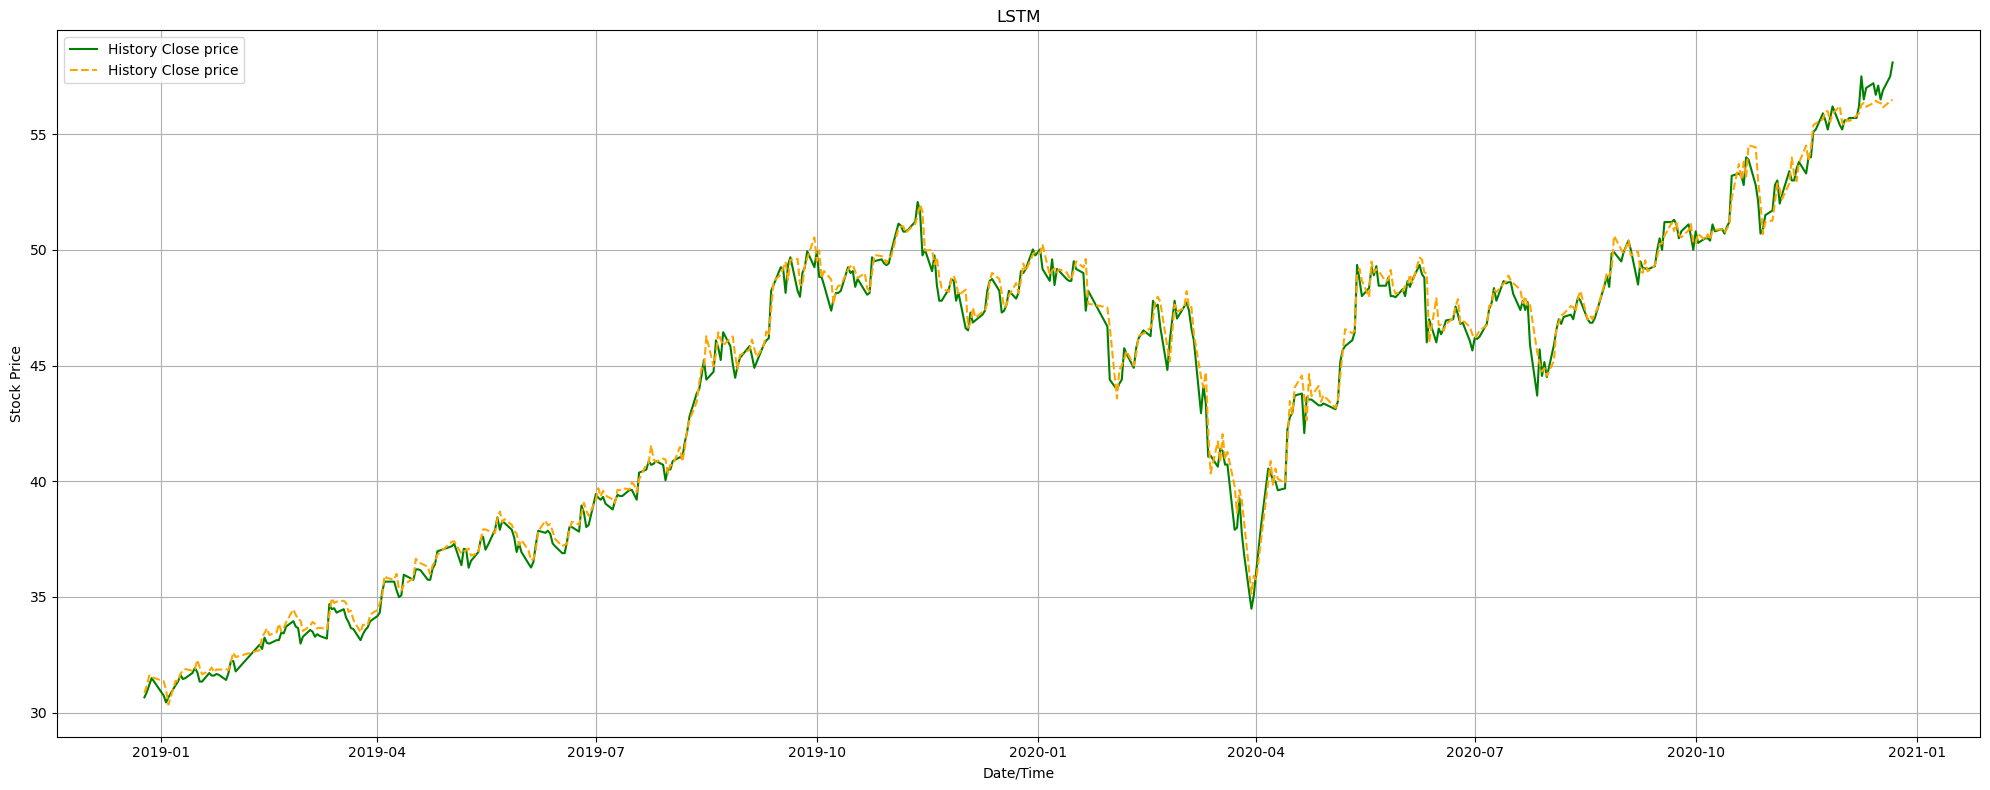

In [44]:
# visualize results

models = ['Random Forest', 'Linear Regression', 'Support Vector Regression', 'LSTM']
close_predictions = ['Close_rf_pred', 'Close_lr_pred', 'Close_svr_pred', 'Close_lstm_pred']

for model, close_pre in zip(models, close_predictions):
    plt.figure(figsize=(20, 8))
    plt.plot(data['Date/Time'], data['Close'], label='History Close price', color='green')
    plt.plot(data['Date/Time'], data[close_pre], label='History Close price', color='orange', linestyle='dashed')
    plt.title(model)
    plt.xlabel('Date/Time')
    plt.ylabel('Stock Price')
    plt.tight_layout()
    plt.legend()
    plt.grid(True)
    plt.show()


## MSN Stock

In [45]:
# load data
df = pd.read_csv('MSN.csv')
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df['Date/Time'] = df['Date/Time'].dt.floor('D') #change to minute(min) hour(h) or day(d)

# groupby 'Date/Time' 
data = df.groupby(['Ticker', pd.Grouper(key='Date/Time')]).agg({
    'Open': 'first',   
    'High': 'max',     
    'Low': 'min',     
    'Close': 'last',   
    'Volume': 'sum',  
    'Open Interest': 'sum' 
}).reset_index()

data

Ticker  Date/Time   Open  High    Low  Close   Volume  Open Interest
0      MSN 2017-12-25  73.10  75.4  73.00   74.2   207370              0
1      MSN 2017-12-26  74.90  75.5  74.30   75.5   403710              0
2      MSN 2017-12-27  74.90  75.7  74.80   75.0   517920              0
3      MSN 2017-12-28  75.00  76.0  74.50   75.7   377030              0
4      MSN 2017-12-29  76.00  77.0  76.00   76.7   226880              0
..     ...        ...    ...   ...    ...    ...      ...            ...
743    MSN 2020-12-16  83.01  83.6  82.91   83.5   648540              0
744    MSN 2020-12-17  83.50  84.3  82.90   84.0  1179730              0
745    MSN 2020-12-18  83.70  84.3  83.70   84.1  1417470              0
746    MSN 2020-12-21  85.00  85.0  83.40   83.8   827020              0
747    MSN 2020-12-22  83.80  84.0  82.50   82.8   805250              0

[748 rows x 8 columns]

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Ticker         748 non-null    object        
 1   Date/Time      748 non-null    datetime64[ns]
 2   Open           748 non-null    float64       
 3   High           748 non-null    float64       
 4   Low            748 non-null    float64       
 5   Close          748 non-null    float64       
 6   Volume         748 non-null    int64         
 7   Open Interest  748 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 46.9+ KB


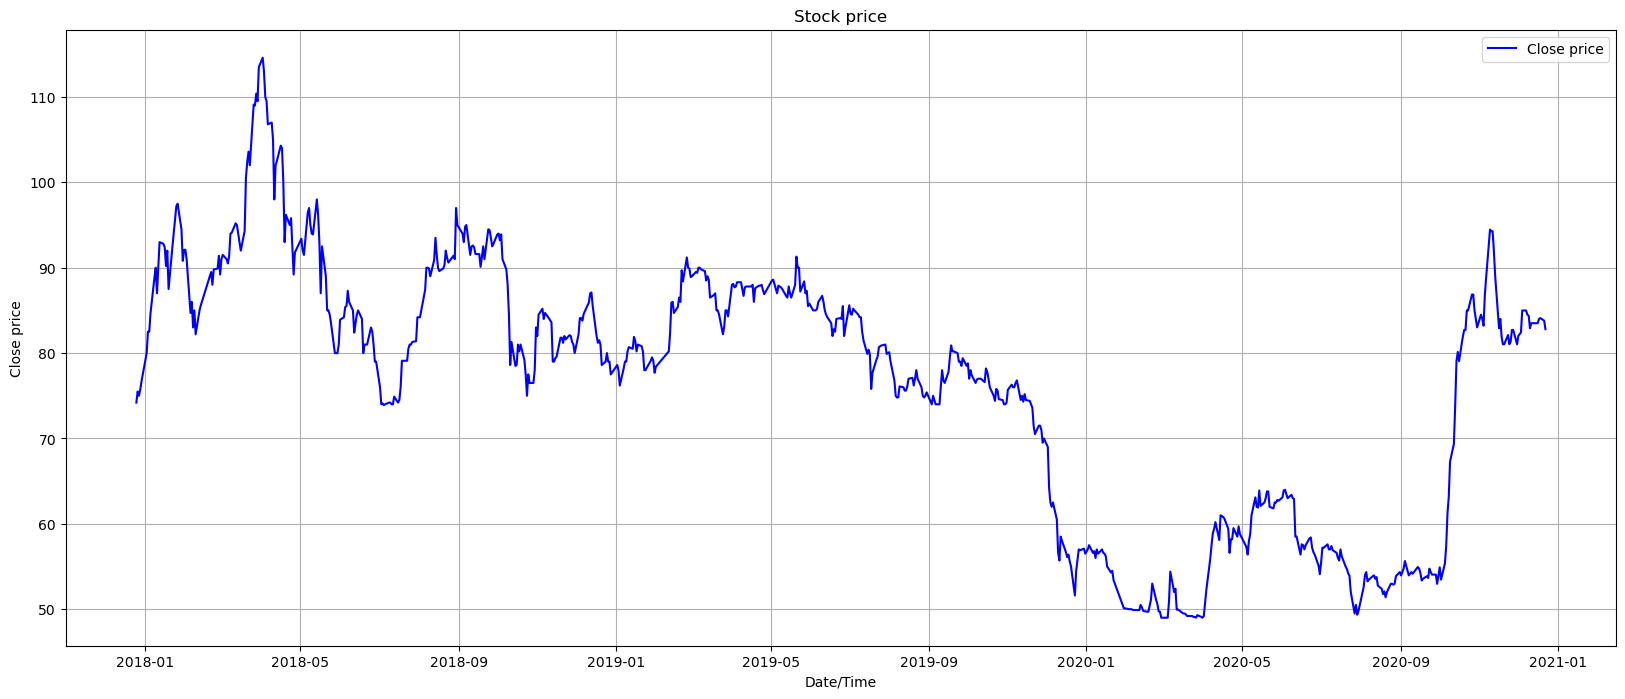

In [47]:
plt.figure(figsize=(20,8))
plt.plot(data['Date/Time'], data['Close'], label='Close price', color='blue')
plt.xlabel('Date/Time')
plt.ylabel('Close price')
plt.title('Stock price')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
# feature
data['Price_fluctuation'] = data['Close'].shift(-1) - data['Close'] 
price_fluctuation = data['Price_fluctuation'].shift(1)

features = ['Open', 'High', 'Low', 'Volume']
X = data[features]
y = data['Close']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_pred = rf_pred.reshape(-1,1)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
print("Random Forest MSE:", rf_mse)
print("Random Forest MAE:", rf_mae)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_pred = lr_pred.reshape(-1,1)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_mae = mean_absolute_error(y_test, lr_pred)
print("Linear Regression MSE:", lr_mse)
print("Linear Regression MAE:", lr_mae)

# Support Vector Regression - SVR
svr_model = SVR()
svr_model.fit(X_train, y_train)
svr_pred = svr_model.predict(X_test)
svr_pred = svr_pred.reshape(-1,1)
svr_mse = mean_squared_error(y_test, svr_pred)
svr_mae = mean_absolute_error(y_test, svr_pred)
print("Support Vector Regression MSE:", svr_mse)
print("Support Vector Regression MAE:", svr_mae)

# LSTM
X_train_lstm = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_train_lstm, y_train, epochs=500, batch_size=32, verbose=2)
lstm_pred = lstm_model.predict(X_test_lstm)
lstm_pred = lstm_pred.reshape(-1,1)
lstm_mse = mean_squared_error(y_test, lstm_pred)
lstm_mae = mean_absolute_error(y_test, lstm_pred)
print("LSTM MSE:", lstm_mse)
print("LSTM MAE:", lstm_mae)


Random Forest MSE: 0.9891668404666639
Random Forest MAE: 0.6863006666666678
Linear Regression MSE: 0.8272272141722491
Linear Regression MAE: 0.6100765348540631
Support Vector Regression MSE: 12.584707543777101
Support Vector Regression MAE: 1.5024060022258303
Epoch 1/500
19/19 - 4s - loss: 5940.2383 - 4s/epoch - 202ms/step
Epoch 2/500
19/19 - 0s - loss: 5880.5068 - 99ms/epoch - 5ms/step
Epoch 3/500
19/19 - 0s - loss: 5698.9023 - 98ms/epoch - 5ms/step
Epoch 4/500
19/19 - 0s - loss: 5135.4600 - 78ms/epoch - 4ms/step
Epoch 5/500
19/19 - 0s - loss: 4411.0044 - 73ms/epoch - 4ms/step
Epoch 6/500
19/19 - 0s - loss: 4022.3394 - 74ms/epoch - 4ms/step
Epoch 7/500
19/19 - 0s - loss: 3800.6138 - 72ms/epoch - 4ms/step
Epoch 8/500
19/19 - 0s - loss: 3627.0981 - 73ms/epoch - 4ms/step
Epoch 9/500
19/19 - 0s - loss: 3474.2239 - 74ms/epoch - 4ms/step
Epoch 10/500
19/19 - 0s - loss: 3334.8503 - 73ms/epoch - 4ms/step
Epoch 11/500
19/19 - 0s - loss: 3205.6741 - 75ms/epoch - 4ms/step
Epoch 12/500
19/19 - 0s

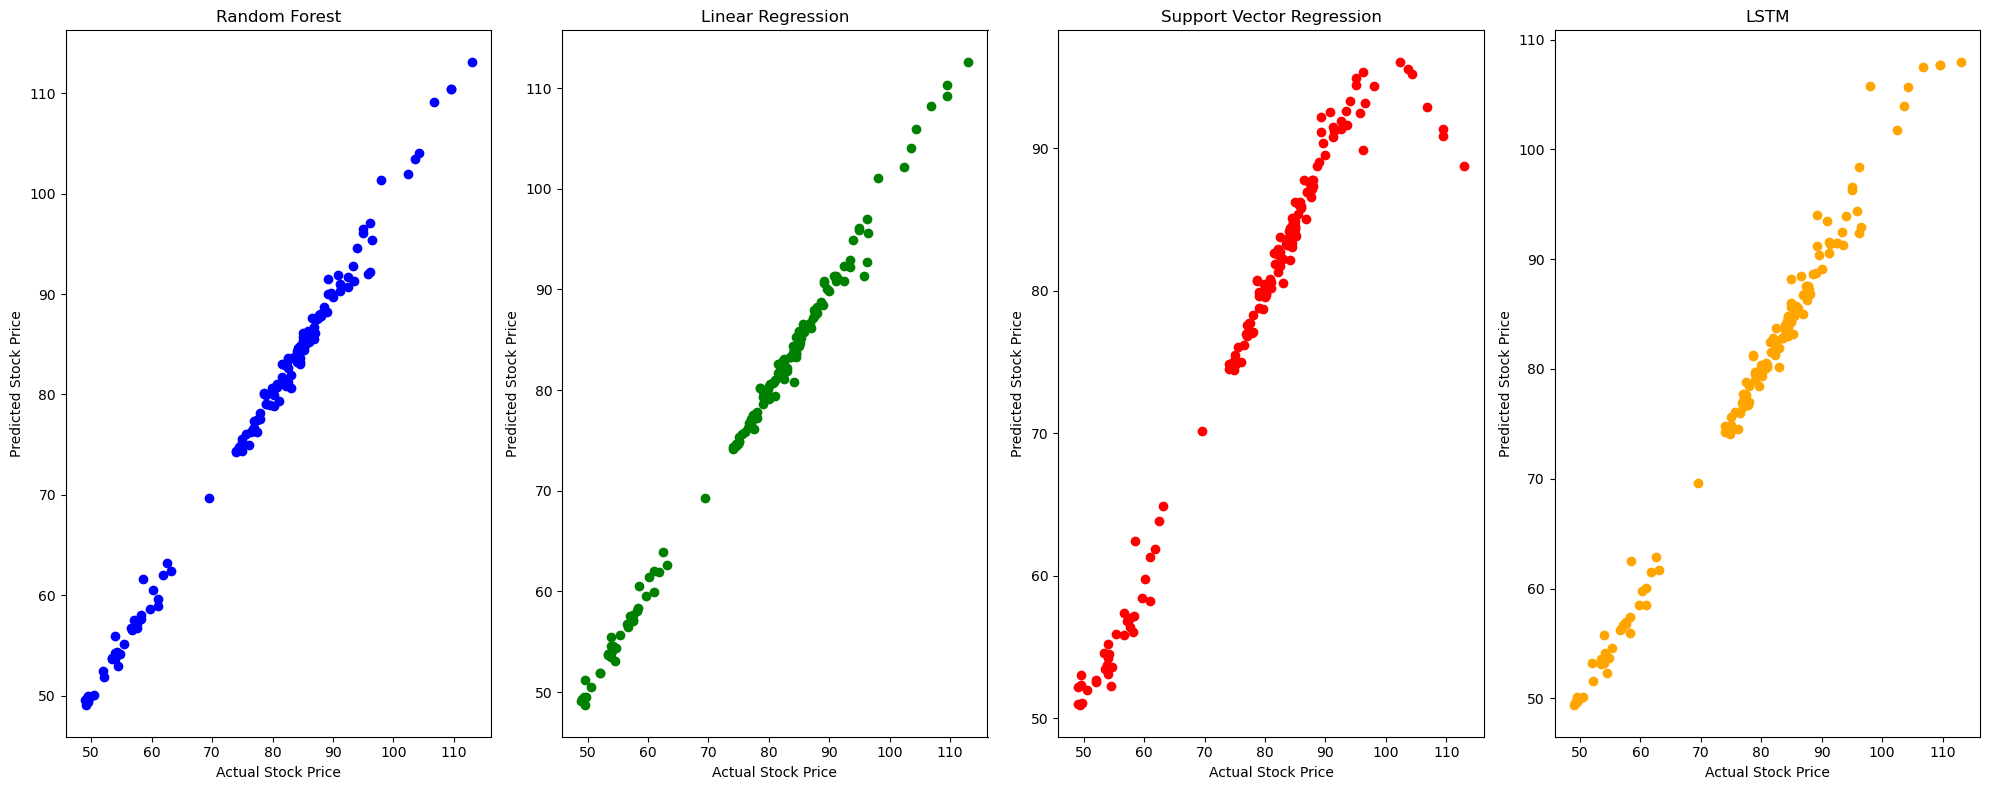

In [50]:
# visualize results
models = ['Random Forest', 'Linear Regression', 'Support Vector Regression', 'LSTM']
result_predictions = [rf_pred, lr_pred, svr_pred, lstm_pred]
colors = ['blue', 'green', 'red', 'orange']

plt.figure(figsize=(20, 8))
for i, (model, result_pred, color) in enumerate(zip(models, result_predictions, colors), 1): 
    plt.subplot(1, 4, i)
    plt.scatter(y_test, result_pred, color=color)
    plt.title(model)
    plt.xlabel('Actual Stock Price')
    plt.ylabel('Predicted Stock Price')
plt.tight_layout()
plt.show()


In [51]:
X_lstm = np.array(X).reshape((X.shape[0], X.shape[1], 1))

rf_prediction = rf_model.predict(X).reshape(-1)  
lr_prediction = lr_model.predict(X).reshape(-1)  
svr_prediction = svr_model.predict(X).reshape(-1)  
lstm_prediction = lstm_model.predict(X_lstm).reshape(-1)  

# add predictions to DataFrame
data['Close_rf_pred'] = rf_prediction
data['Close_lr_pred'] = lr_prediction
data['Close_svr_pred'] = svr_prediction
data['Close_lstm_pred'] = lstm_prediction

# calculate price fluctuation predictions
data['Price_flu_rf_pred'] = data['Close_rf_pred'].shift(-1) - data['Close_rf_pred']
price_flu_rf_pred = data['Price_flu_rf_pred'].shift(1) 
data['Price_flu_lr_pred'] = data['Close_lr_pred'].shift(-1) - data['Close_lr_pred'] 
price_flu_lr_pred = data['Price_flu_lr_pred'].shift(1)
data['Price_flu_svr_pred'] = data['Close_svr_pred'].shift(-1) - data['Close_svr_pred'] 
price_flu_svr_pred = data['Price_flu_svr_pred'].shift(1)
data['Price_flu_lstm_pred'] = data['Close_lstm_pred'].shift(-1) - data['Close_lstm_pred']
price_flu_lstm_pred = data['Price_flu_lstm_pred'].shift(1)

print('Price Fluctuation')
# compare dataframe
compare = pd.DataFrame({
    'Date/Time': data['Date/Time'],
    'Close price test': y,
    'Close price change': price_fluctuation,
    'Close rf pred': rf_prediction,
    'Price change rf pred': price_flu_rf_pred,
    'Close lr pred': lr_prediction,
    'Price change lr pred': price_flu_lr_pred,
    'Close svr pred': svr_prediction,
    'Price change svr pred': price_flu_svr_pred,    
    'Close lstm pred': lstm_prediction,
    'Price change lstm pred': price_flu_lstm_pred
})
compare


24/24 [==============================] - 0s 3ms/step
Price Fluctuation


Date/Time  Close price test  Close price change  Close rf pred  \
0   2017-12-25              74.2                 NaN        74.2442   
1   2017-12-26              75.5                 1.3        75.2410   
2   2017-12-27              75.0                -0.5        75.2290   
3   2017-12-28              75.7                 0.7        75.6050   
4   2017-12-29              76.7                 1.0        76.5630   
..         ...               ...                 ...            ...   
743 2020-12-16              83.5                 0.0        83.7201   
744 2020-12-17              84.0                 0.5        83.6988   
745 2020-12-18              84.1                 0.1        84.0401   
746 2020-12-21              83.8                -0.3        84.0457   
747 2020-12-22              82.8                -1.0        83.1003   

     Price change rf pred  Close lr pred  Price change lr pred  \
0                     NaN      74.767217                   NaN   
1                  0.9968      74.790064              0.022847   
2                 -0.0120      75.342926              0.552862   
3                  0.3760      75.298036             -0.044890   
4                  0.9580      76.647419              1.349383   
..                    ...            ...                   ...   
743                0.2457      83.296770              0.078041   
744               -0.0213      83.665963              0.369193   
745                0.3413      84.171392              0.505429   
746                0.0056      83.706743             -0.464650   
747               -0.9454      82.893450             -0.813293   

     Close svr pred  Price change svr pred  Close lstm pred  \
0         74.100077                    NaN        73.389648   
1         74.911480               0.811403        74.679924   
2         75.187618               0.276138        74.859741   
3         75.211092               0.023474        74.941566   
4         76.353825               1.142733        75.966545   
..              ...                    ...              ...   
743       83.308329              -0.238098        82.809021   
744       83.795193               0.486864        83.567810   
745       84.131013               0.335820        83.876251   
746       84.565568               0.434554        84.563202   
747       83.507009              -1.058559        83.403839   

     Price change lstm pred  
0                       NaN  
1                  1.290276  
2                  0.179817  
3                  0.081825  
4                  1.024979  
..                      ...  
743               -0.460854  
744                0.758789  
745                0.308441  
746                0.686951  
747               -1.159363  

[748 rows x 11 columns]

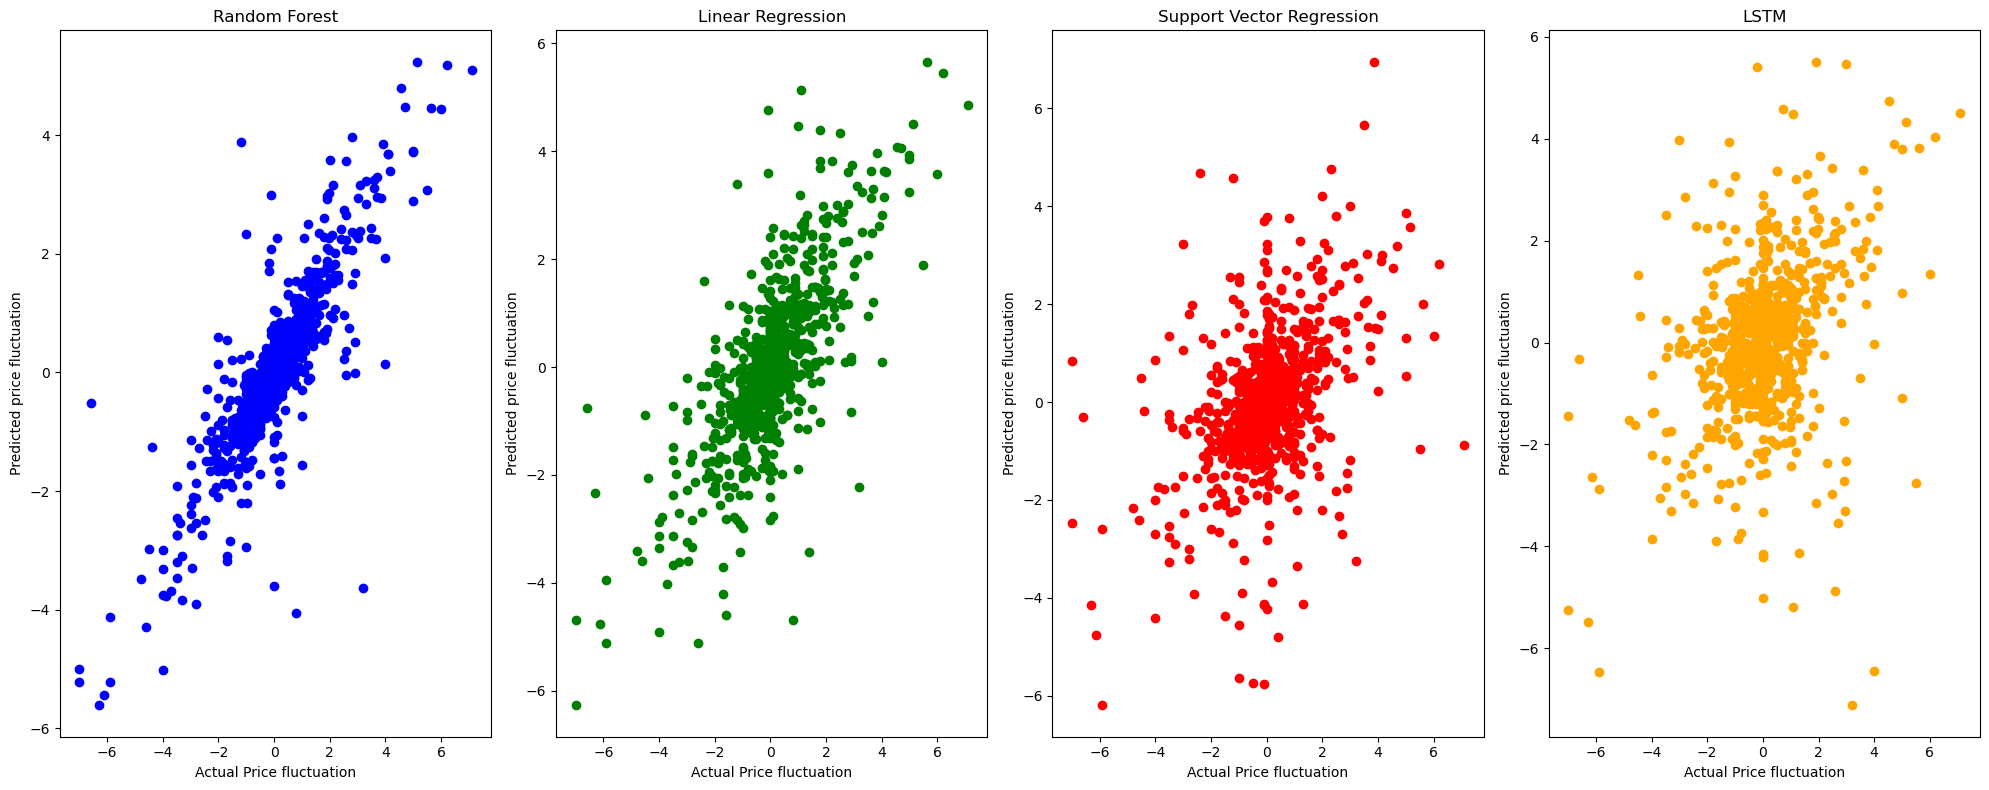

In [52]:
# visualize results

models = ['Random Forest', 'Linear Regression', 'Support Vector Regression', 'LSTM']
price_flu_predictions = ['Price_flu_rf_pred', 'Price_flu_lr_pred', 'Price_flu_svr_pred', 'Price_flu_lstm_pred']
colors = ['blue', 'green', 'red', 'orange']

plt.figure(figsize=(20, 8))
for i, (model, price_flu_pre, color) in enumerate(zip(models, price_flu_predictions, colors), 1):

    plt.subplot(1, 4, i)
    plt.scatter(data['Price_fluctuation'], data[price_flu_pre], color=color)
    plt.title(model)
    plt.xlabel('Actual Price fluctuation')
    plt.ylabel('Predicted price fluctuation')
plt.tight_layout()
plt.show()

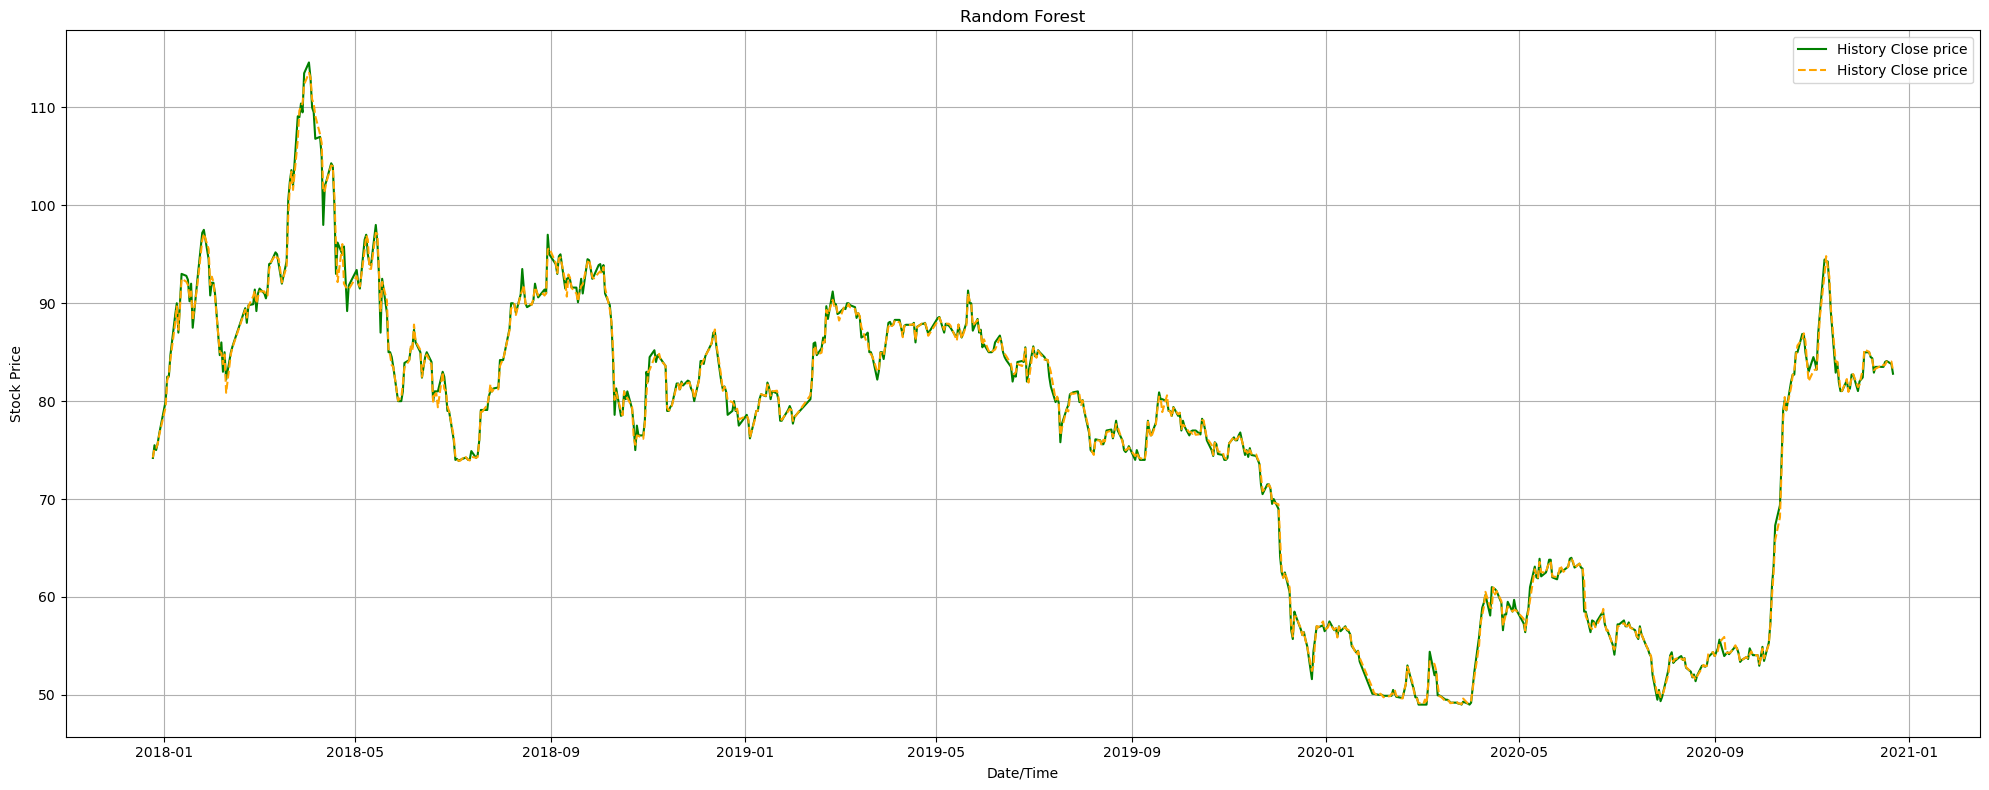

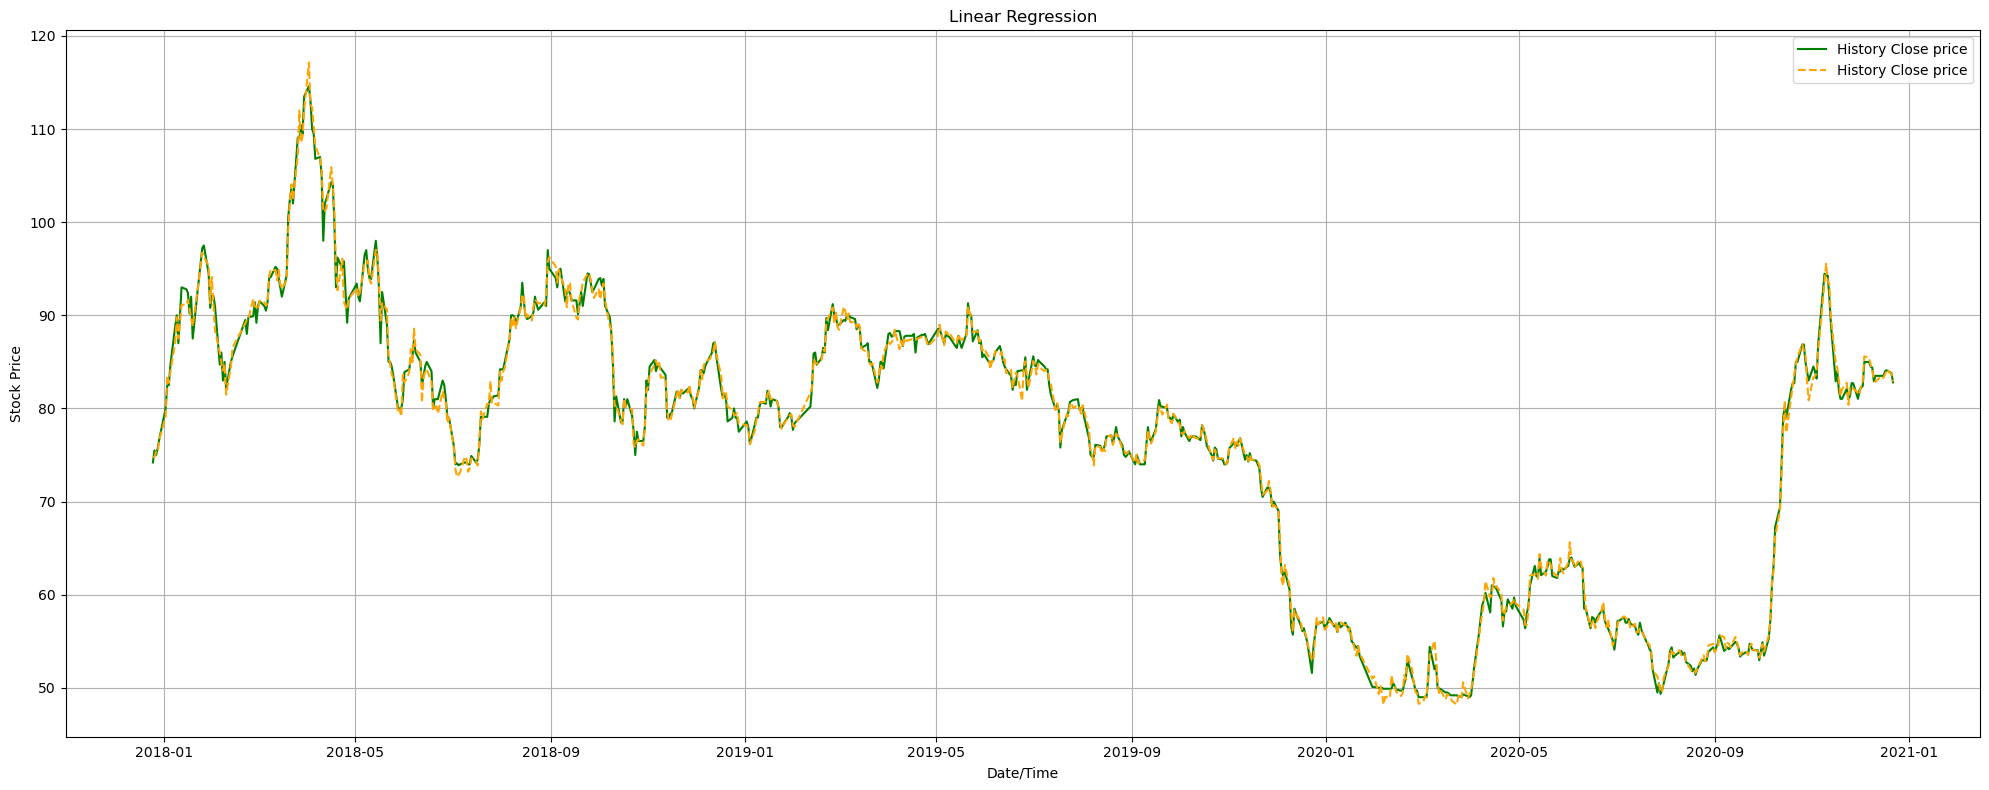

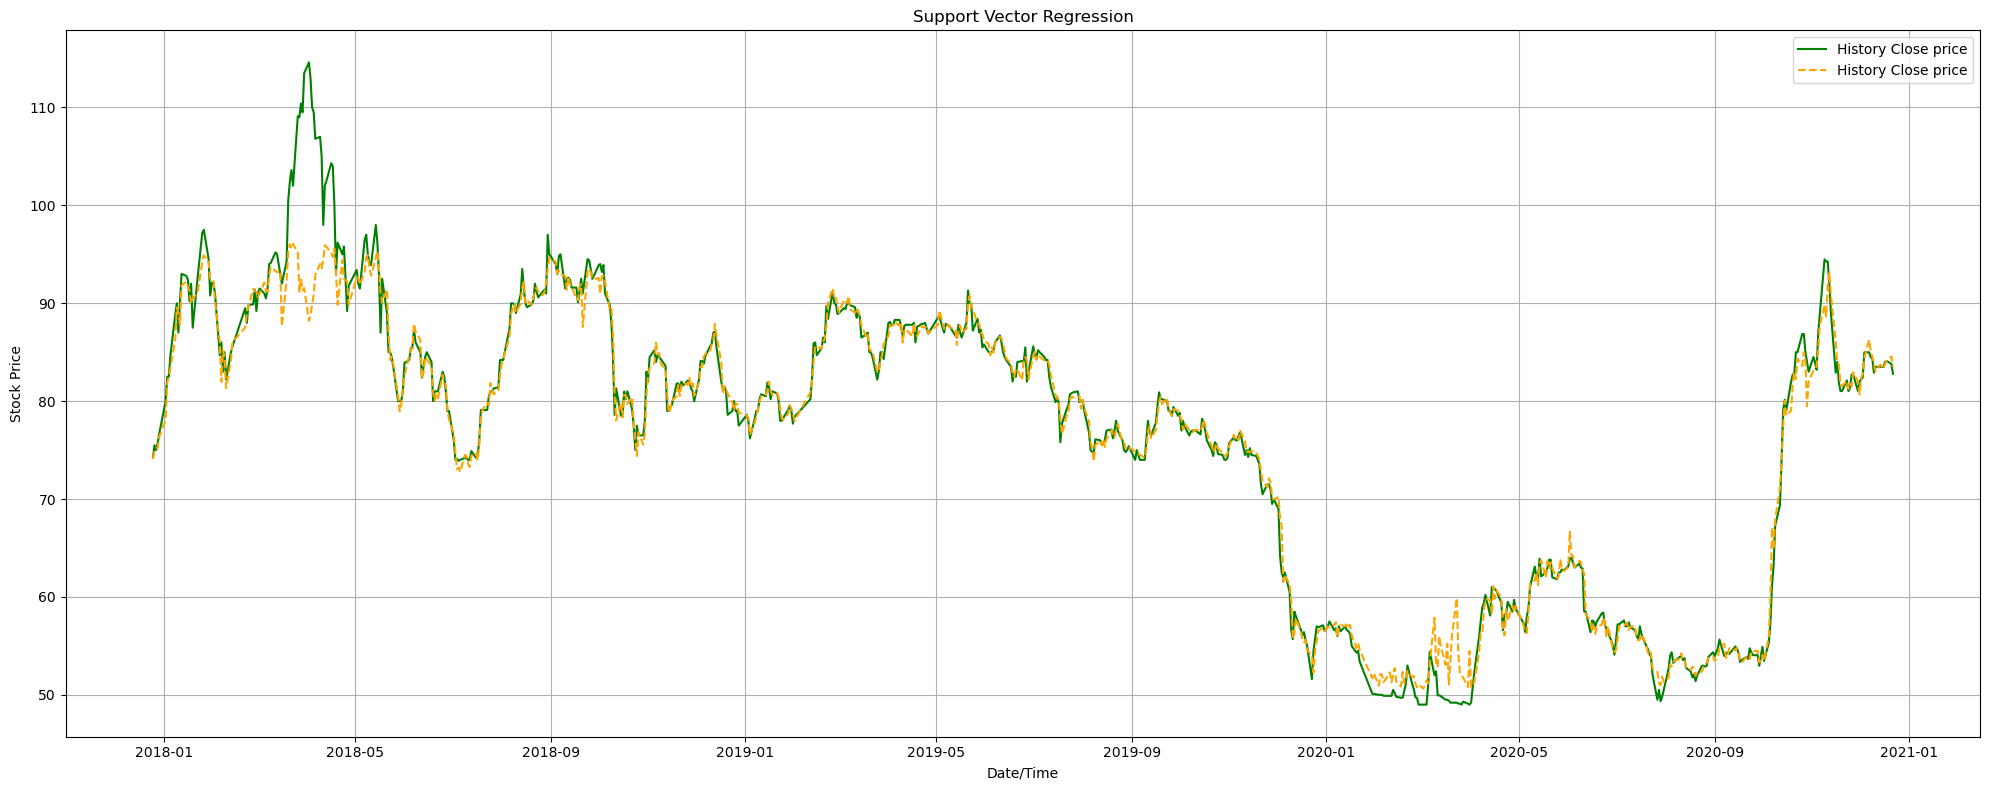

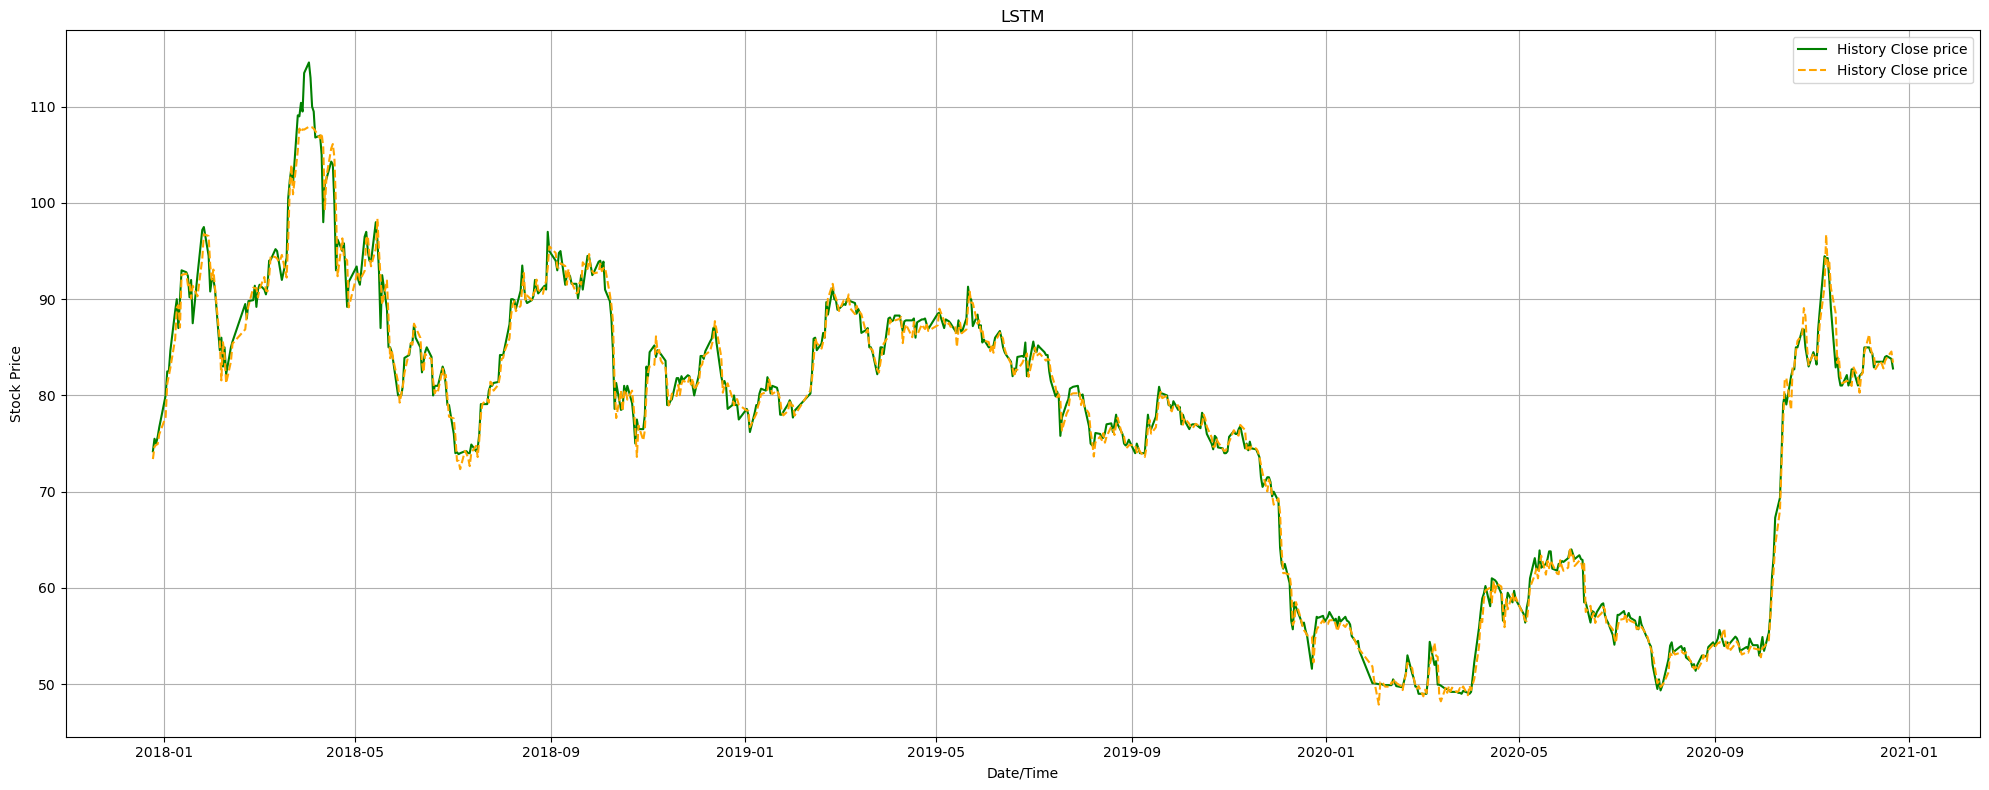

In [53]:
# visualize results

models = ['Random Forest', 'Linear Regression', 'Support Vector Regression', 'LSTM']
close_predictions = ['Close_rf_pred', 'Close_lr_pred', 'Close_svr_pred', 'Close_lstm_pred']

for model, close_pre in zip(models, close_predictions):
    plt.figure(figsize=(20, 8))
    plt.plot(data['Date/Time'], data['Close'], label='History Close price', color='green')
    plt.plot(data['Date/Time'], data[close_pre], label='History Close price', color='orange', linestyle='dashed')
    plt.title(model)
    plt.xlabel('Date/Time')
    plt.ylabel('Stock Price')
    plt.tight_layout()
    plt.legend()
    plt.grid(True)
    plt.show()


## VIC Stock

In [54]:
# load data
df = pd.read_csv('VIC.csv')
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df['Date/Time'] = df['Date/Time'].dt.floor('D') #change to minute(min) hour(h) or day(d)

# groupby 'Date/Time' 
data = df.groupby(['Ticker', pd.Grouper(key='Date/Time')]).agg({
    'Open': 'first',   
    'High': 'max',     
    'Low': 'min',     
    'Close': 'last',   
    'Volume': 'sum',  
    'Open Interest': 'sum' 
}).reset_index()

data

Ticker  Date/Time   Open   High    Low  Close   Volume  Open Interest
0      VIC 2018-10-17   98.5   99.6   98.3   99.0  1266610              0
1      VIC 2018-10-18   98.5   99.2   98.0   99.1   896140              0
2      VIC 2018-10-19   96.5   99.1   96.5   99.1   915870              0
3      VIC 2018-10-22   98.1   99.6   97.1   99.1   536930              0
4      VIC 2018-10-23   98.1   99.0   96.5   99.0   608750              0
..     ...        ...    ...    ...    ...    ...      ...            ...
543    VIC 2020-12-16  106.8  107.1  105.9  107.0   756200              0
544    VIC 2020-12-17  106.3  106.9  104.7  104.7  1352580              0
545    VIC 2020-12-18  104.7  106.1  104.5  104.7  1350780              0
546    VIC 2020-12-21  105.5  106.4  104.9  106.4   587100              0
547    VIC 2020-12-22  106.0  107.0  105.3  105.7   518320              0

[548 rows x 8 columns]

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Ticker         548 non-null    object        
 1   Date/Time      548 non-null    datetime64[ns]
 2   Open           548 non-null    float64       
 3   High           548 non-null    float64       
 4   Low            548 non-null    float64       
 5   Close          548 non-null    float64       
 6   Volume         548 non-null    int64         
 7   Open Interest  548 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 34.4+ KB


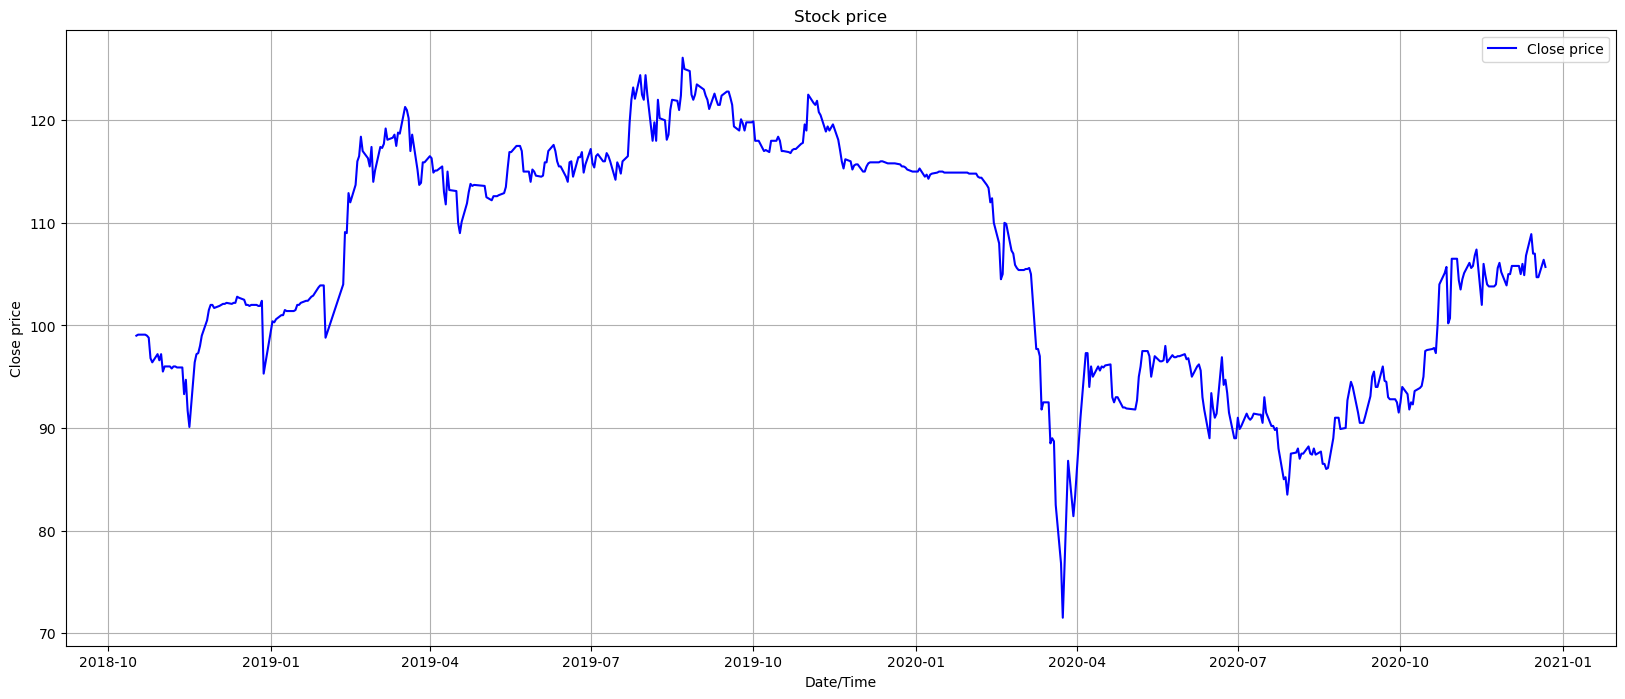

In [56]:
plt.figure(figsize=(20,8))
plt.plot(data['Date/Time'], data['Close'], label='Close price', color='blue')
plt.xlabel('Date/Time')
plt.ylabel('Close price')
plt.title('Stock price')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
# feature 
data['Price_fluctuation'] = data['Close'].shift(-1) - data['Close'] 
price_fluctuation = data['Price_fluctuation'].shift(1)

features = ['Open', 'High', 'Low', 'Volume']
X = data[features]
y = data['Close']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_pred = rf_pred.reshape(-1,1)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
print("Random Forest MSE:", rf_mse)
print("Random Forest MAE:", rf_mae)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_pred = lr_pred.reshape(-1,1)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_mae = mean_absolute_error(y_test, lr_pred)
print("Linear Regression MSE:", lr_mse)
print("Linear Regression MAE:", lr_mae)

# Support Vector Regression - SVR
svr_model = SVR()
svr_model.fit(X_train, y_train)
svr_pred = svr_model.predict(X_test)
svr_pred = svr_pred.reshape(-1,1)
svr_mse = mean_squared_error(y_test, svr_pred)
svr_mae = mean_absolute_error(y_test, svr_pred)
print("Support Vector Regression MSE:", svr_mse)
print("Support Vector Regression MAE:", svr_mae)

# LSTM
X_train_lstm = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_train_lstm, y_train, epochs=500, batch_size=32, verbose=2)
lstm_pred = lstm_model.predict(X_test_lstm)
lstm_pred = lstm_pred.reshape(-1,1)
lstm_mse = mean_squared_error(y_test, lstm_pred)
lstm_mae = mean_absolute_error(y_test, lstm_pred)
print("LSTM MSE:", lstm_mse)
print("LSTM MAE:", lstm_mae)


Random Forest MSE: 1.2202701727272884
Random Forest MAE: 0.7913181818181869
Linear Regression MSE: 0.6109464166700181
Linear Regression MAE: 0.6082214076587977
Support Vector Regression MSE: 2.3603398062830756
Support Vector Regression MAE: 0.9144464453363897
Epoch 1/500
14/14 - 4s - loss: 11335.2109 - 4s/epoch - 295ms/step
Epoch 2/500
14/14 - 0s - loss: 11268.0391 - 66ms/epoch - 5ms/step
Epoch 3/500
14/14 - 0s - loss: 11150.9521 - 63ms/epoch - 4ms/step
Epoch 4/500
14/14 - 0s - loss: 10876.1758 - 64ms/epoch - 5ms/step
Epoch 5/500
14/14 - 0s - loss: 10274.6875 - 63ms/epoch - 4ms/step
Epoch 6/500
14/14 - 0s - loss: 9472.3672 - 60ms/epoch - 4ms/step
Epoch 7/500
14/14 - 0s - loss: 8883.4814 - 60ms/epoch - 4ms/step
Epoch 8/500
14/14 - 0s - loss: 8533.2100 - 58ms/epoch - 4ms/step
Epoch 9/500
14/14 - 0s - loss: 8285.6074 - 59ms/epoch - 4ms/step
Epoch 10/500
14/14 - 0s - loss: 8078.7871 - 58ms/epoch - 4ms/step
Epoch 11/500
14/14 - 0s - loss: 7892.3242 - 59ms/epoch - 4ms/step
Epoch 12/500
14/14

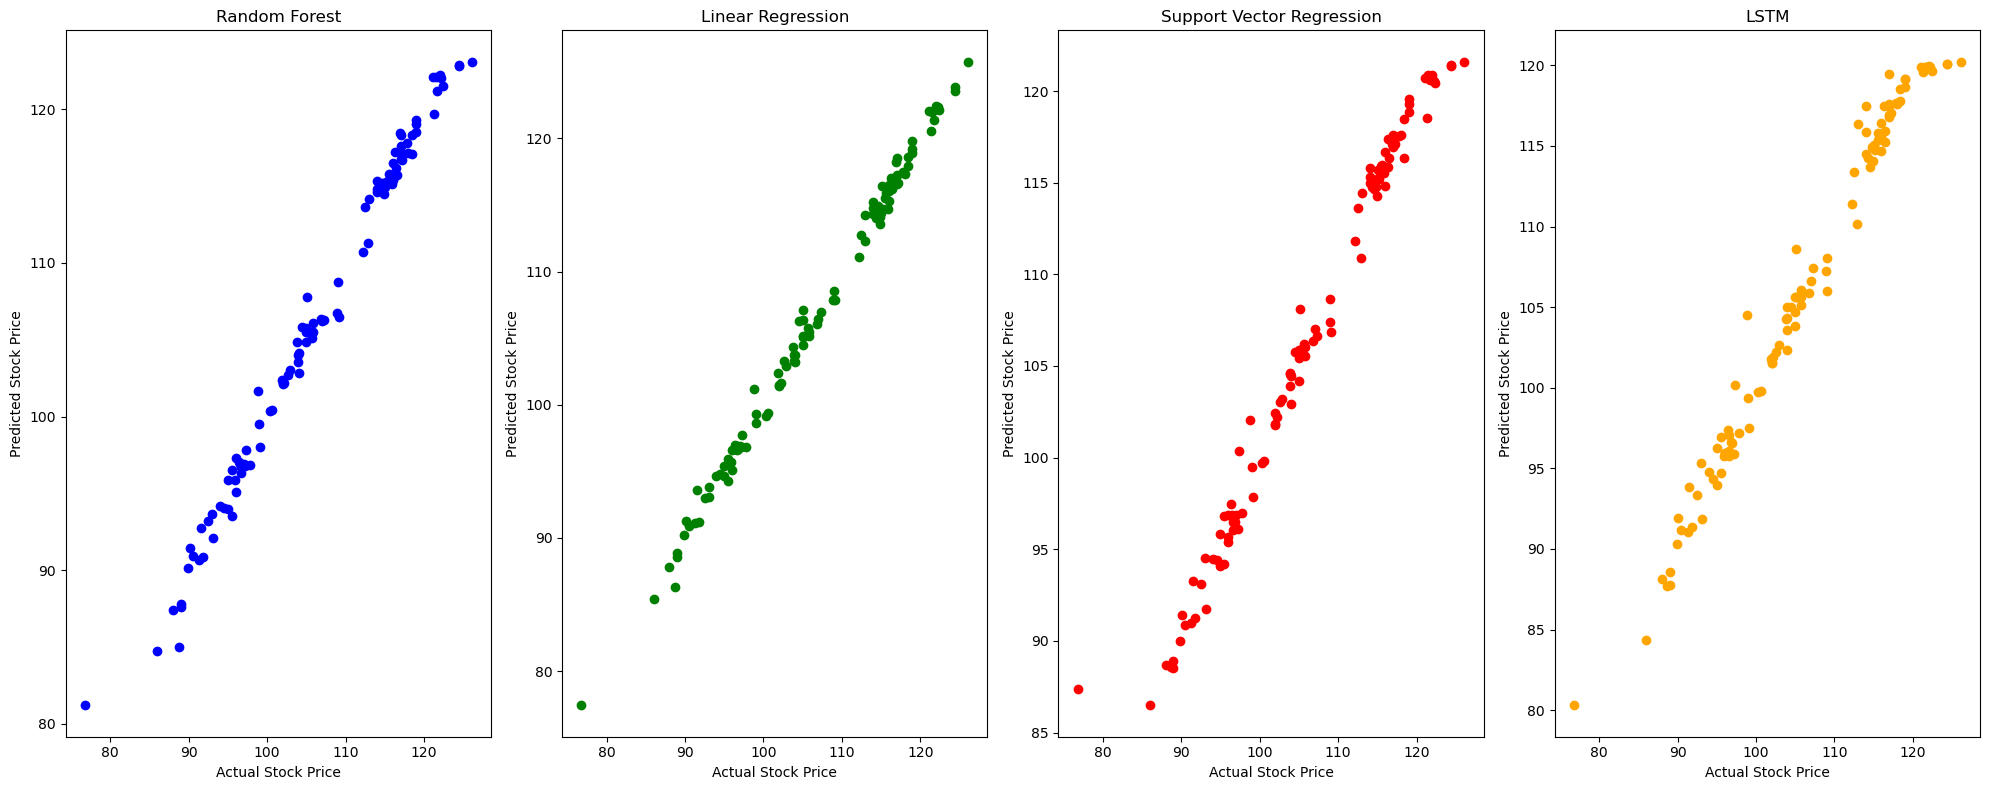

In [59]:
# visualize results
models = ['Random Forest', 'Linear Regression', 'Support Vector Regression', 'LSTM']
result_predictions = [rf_pred, lr_pred, svr_pred, lstm_pred]
colors = ['blue', 'green', 'red', 'orange']

plt.figure(figsize=(20, 8))
for i, (model, result_pred, color) in enumerate(zip(models, result_predictions, colors), 1): 
    plt.subplot(1, 4, i)
    plt.scatter(y_test, result_pred, color=color)
    plt.title(model)
    plt.xlabel('Actual Stock Price')
    plt.ylabel('Predicted Stock Price')
plt.tight_layout()
plt.show()


In [60]:
X_lstm = np.array(X).reshape((X.shape[0], X.shape[1], 1))

rf_prediction = rf_model.predict(X).reshape(-1)  
lr_prediction = lr_model.predict(X).reshape(-1)  
svr_prediction = svr_model.predict(X).reshape(-1)  
lstm_prediction = lstm_model.predict(X_lstm).reshape(-1)  

# add predictions to DataFrame
data['Close_rf_pred'] = rf_prediction
data['Close_lr_pred'] = lr_prediction
data['Close_svr_pred'] = svr_prediction
data['Close_lstm_pred'] = lstm_prediction

# calculate price fluctuation predictions
data['Price_flu_rf_pred'] = data['Close_rf_pred'].shift(-1) - data['Close_rf_pred']
price_flu_rf_pred = data['Price_flu_rf_pred'].shift(1) 
data['Price_flu_lr_pred'] = data['Close_lr_pred'].shift(-1) - data['Close_lr_pred'] 
price_flu_lr_pred = data['Price_flu_lr_pred'].shift(1)
data['Price_flu_svr_pred'] = data['Close_svr_pred'].shift(-1) - data['Close_svr_pred'] 
price_flu_svr_pred = data['Price_flu_svr_pred'].shift(1)
data['Price_flu_lstm_pred'] = data['Close_lstm_pred'].shift(-1) - data['Close_lstm_pred']
price_flu_lstm_pred = data['Price_flu_lstm_pred'].shift(1)

print('Price Fluctuation')
# compare dataframe
compare = pd.DataFrame({
    'Date/Time': data['Date/Time'],
    'Close price test': y,
    'Close price change': price_fluctuation,
    'Close rf pred': rf_prediction,
    'Price change rf pred': price_flu_rf_pred,
    'Close lr pred': lr_prediction,
    'Price change lr pred': price_flu_lr_pred,
    'Close svr pred': svr_prediction,
    'Price change svr pred': price_flu_svr_pred,    
    'Close lstm pred': lstm_prediction,
    'Price change lstm pred': price_flu_lstm_pred
})
compare


18/18 [==============================] - 0s 3ms/step
Price Fluctuation


Date/Time  Close price test  Close price change  Close rf pred  \
0   2018-10-17              99.0                 NaN         99.483   
1   2018-10-18              99.1                 0.1         99.346   
2   2018-10-19              99.1                 0.0         97.997   
3   2018-10-22              99.1                 0.0         98.997   
4   2018-10-23              99.0                -0.1         98.291   
..         ...               ...                 ...            ...   
543 2020-12-16             107.0                 0.0        106.248   
544 2020-12-17             104.7                -2.3        104.841   
545 2020-12-18             104.7                 0.0        104.967   
546 2020-12-21             106.4                 1.7        106.270   
547 2020-12-22             105.7                -0.7        105.964   

     Price change rf pred  Close lr pred  Price change lr pred  \
0                     NaN      99.267813                   NaN   
1                  -0.137      98.721907             -0.545906   
2                  -1.349      98.616196             -0.105711   
3                   1.000      98.698427              0.082231   
4                  -0.706      97.874866             -0.823561   
..                    ...            ...                   ...   
543                -1.216     106.450305             -1.259800   
544                -1.407     105.906735             -0.543570   
545                 0.126     105.734574             -0.172162   
546                 1.303     105.803015              0.068442   
547                -0.306     106.327313              0.524298   

     Close svr pred  Price change svr pred  Close lstm pred  \
0         99.496947                    NaN        99.371056   
1         98.911147              -0.585800        98.848206   
2         97.854338              -1.056809        97.471474   
3         98.461871               0.607533        98.284775   
4         97.985806              -0.476065        98.108368   
..              ...                    ...              ...   
543      107.022495              -1.108189       106.599823   
544      105.939925              -1.082570       106.574905   
545      105.242604              -0.697321       105.513680   
546      106.098714               0.856110       105.509499   
547      106.600343               0.501629       105.929428   

     Price change lstm pred  
0                       NaN  
1                 -0.522850  
2                 -1.376732  
3                  0.813301  
4                 -0.176407  
..                      ...  
543               -2.103577  
544               -0.024918  
545               -1.061226  
546               -0.004181  
547                0.419930  

[548 rows x 11 columns]

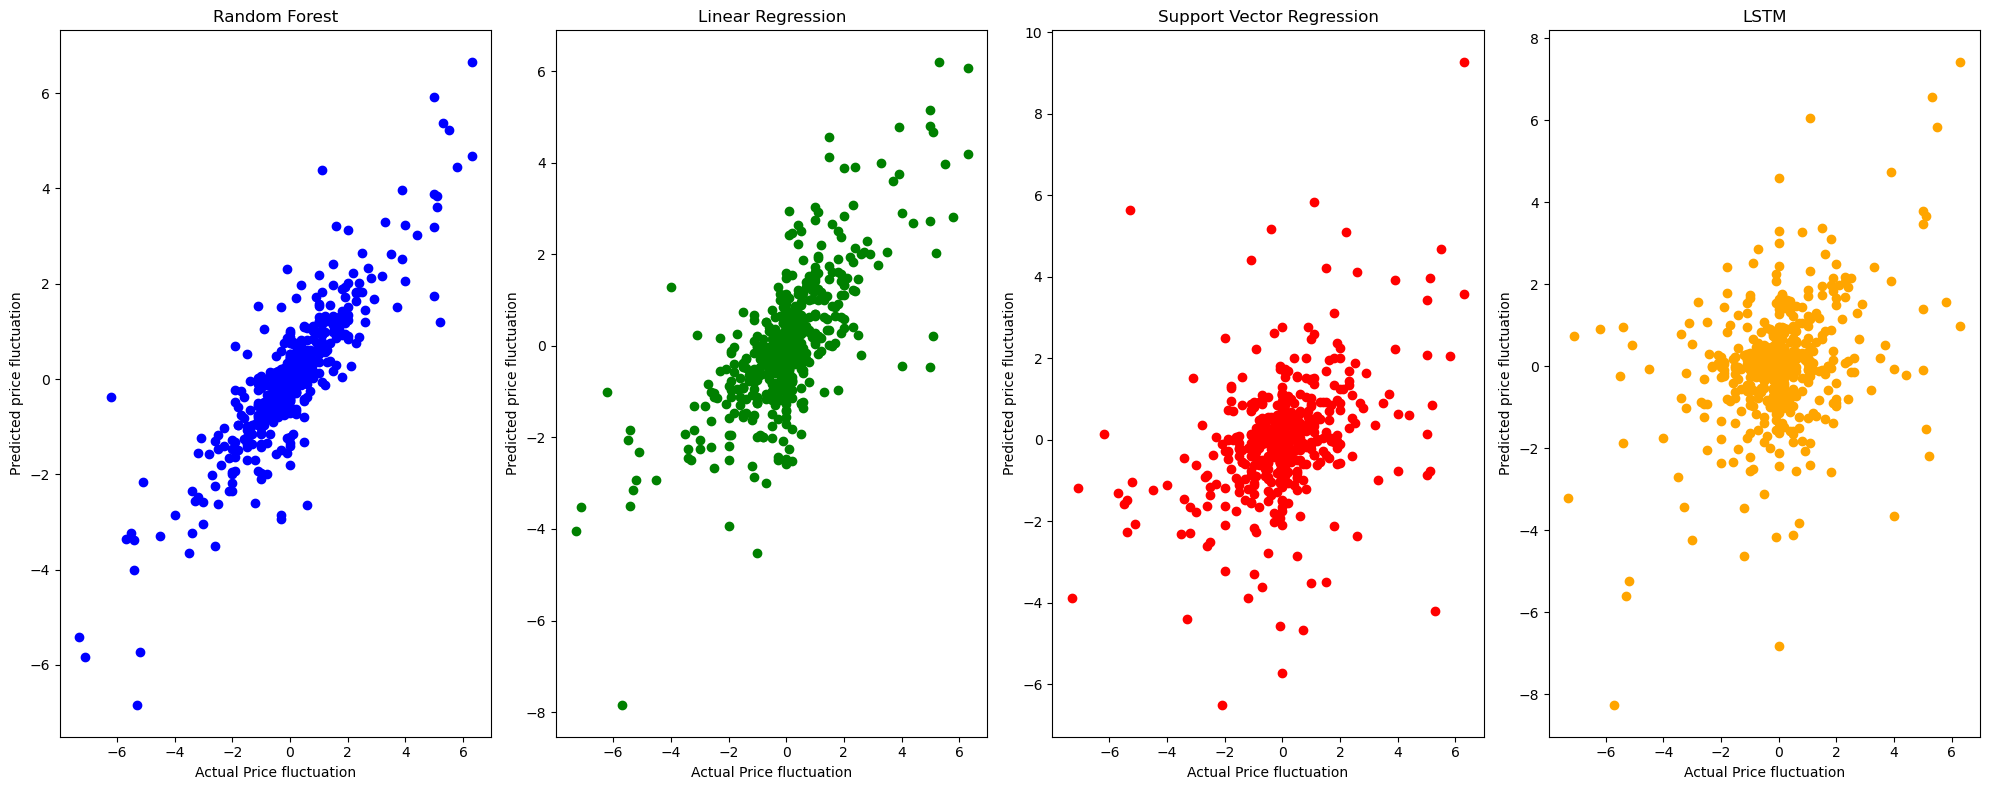

In [61]:
# visualize results

models = ['Random Forest', 'Linear Regression', 'Support Vector Regression', 'LSTM']
price_flu_predictions = ['Price_flu_rf_pred', 'Price_flu_lr_pred', 'Price_flu_svr_pred', 'Price_flu_lstm_pred']
colors = ['blue', 'green', 'red', 'orange']

plt.figure(figsize=(20, 8))
for i, (model, price_flu_pre, color) in enumerate(zip(models, price_flu_predictions, colors), 1):

    plt.subplot(1, 4, i)
    plt.scatter(data['Price_fluctuation'], data[price_flu_pre], color=color)
    plt.title(model)
    plt.xlabel('Actual Price fluctuation')
    plt.ylabel('Predicted price fluctuation')
plt.tight_layout()
plt.show()

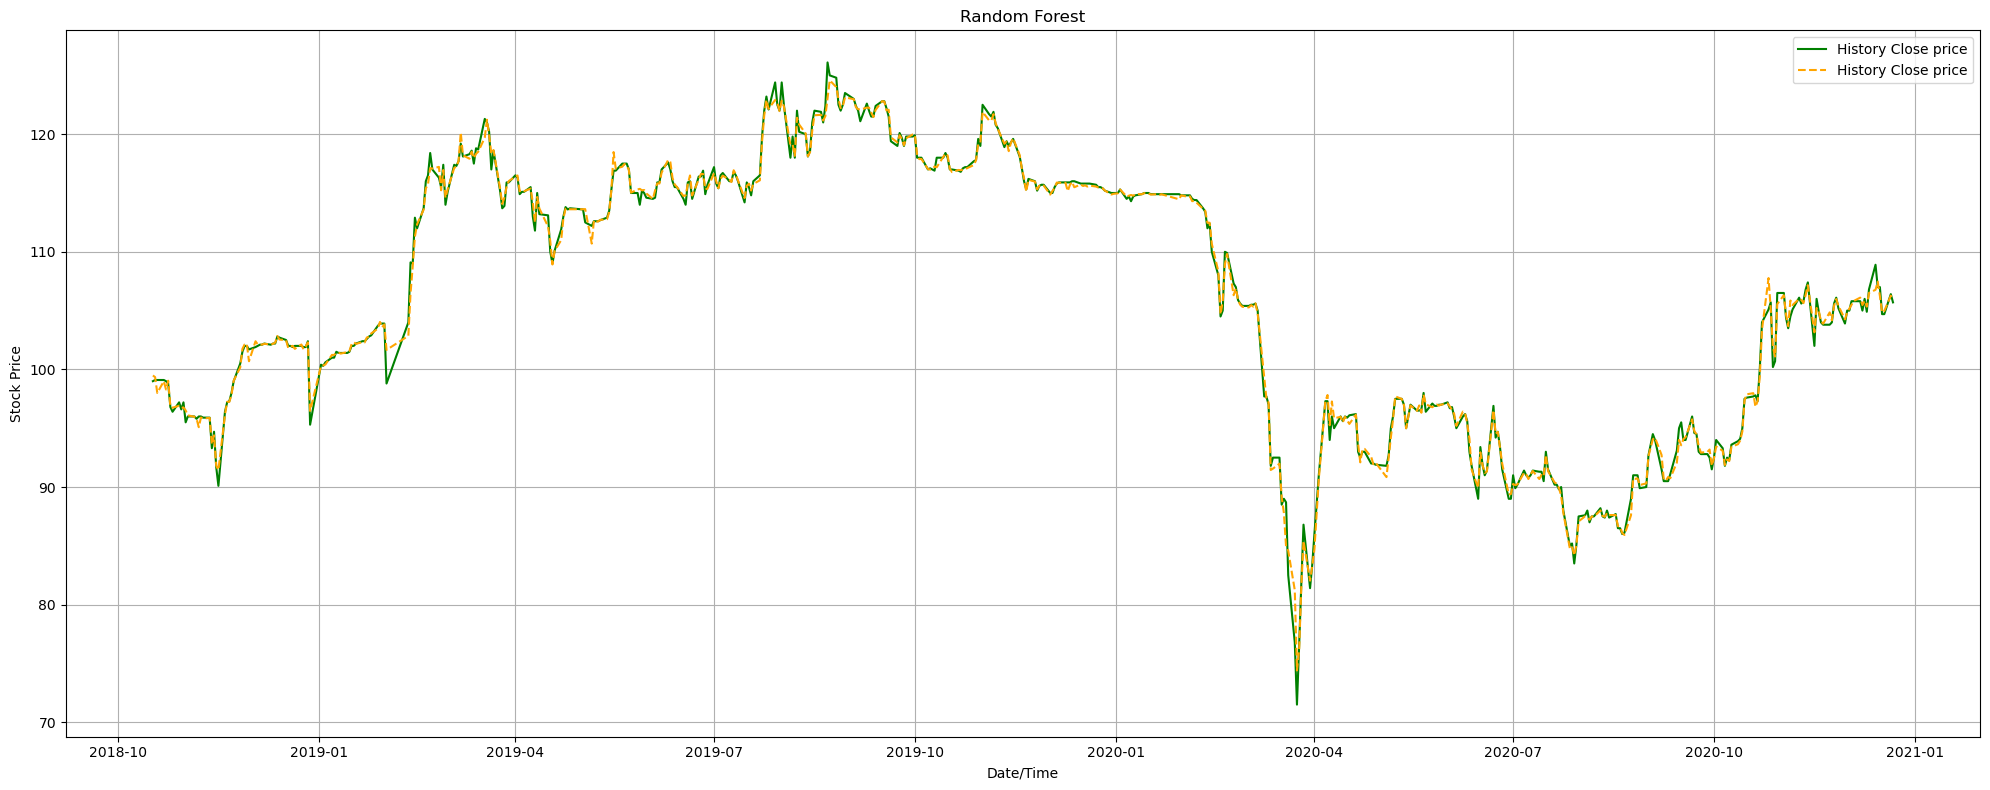

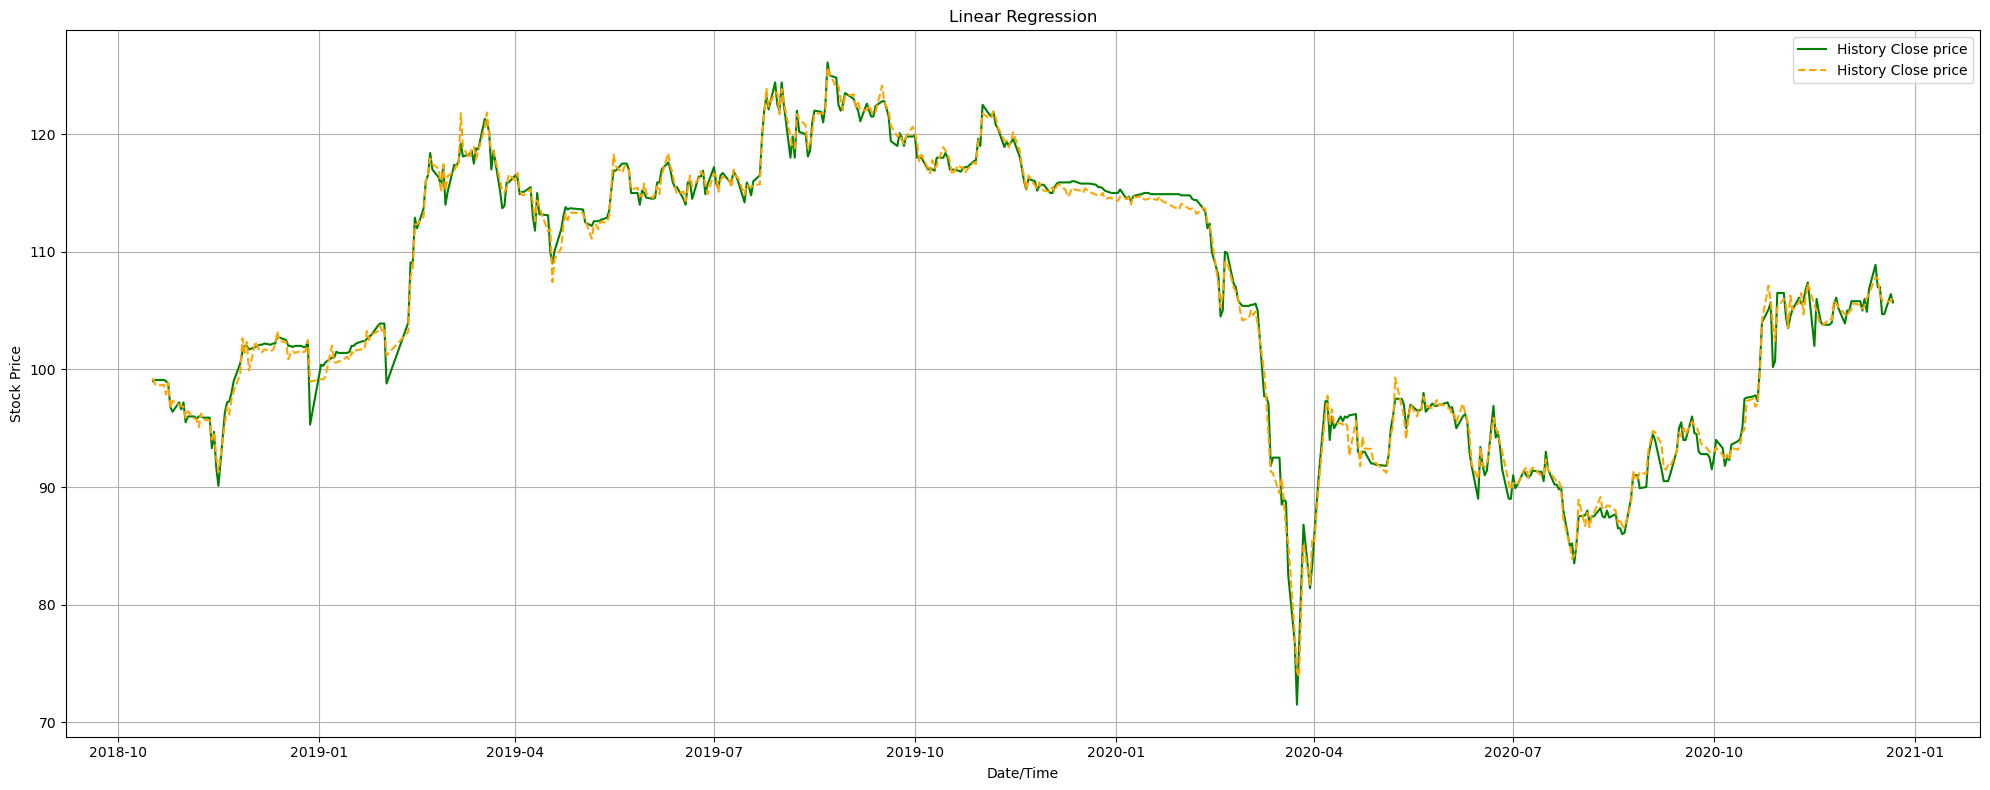

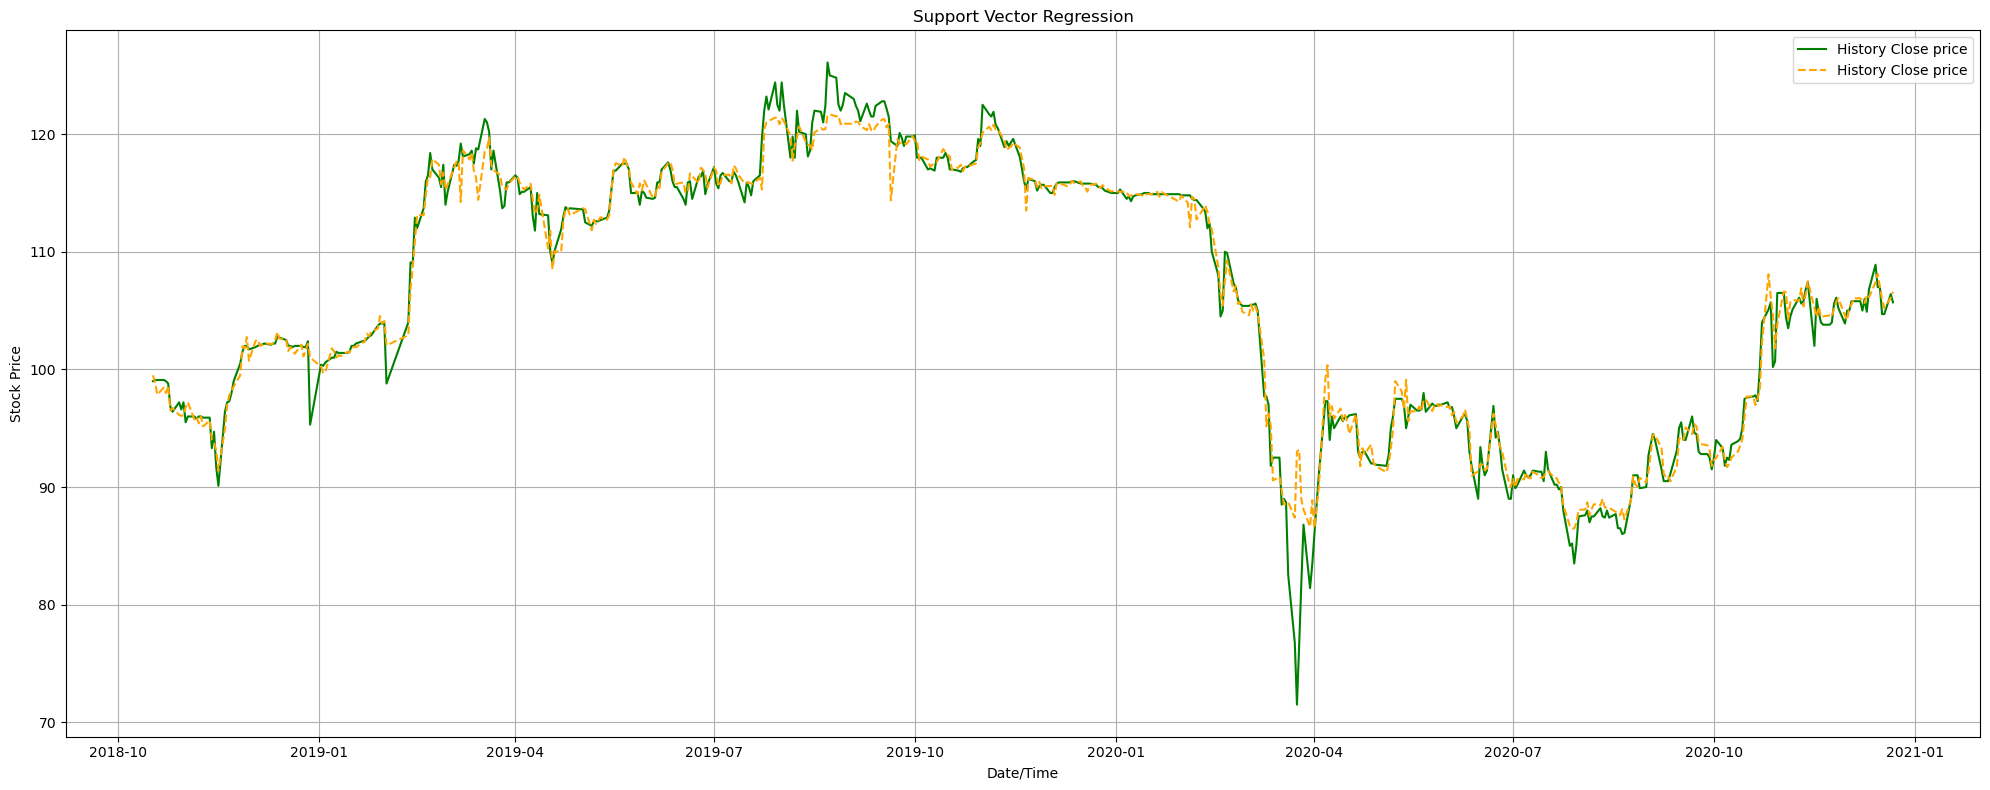

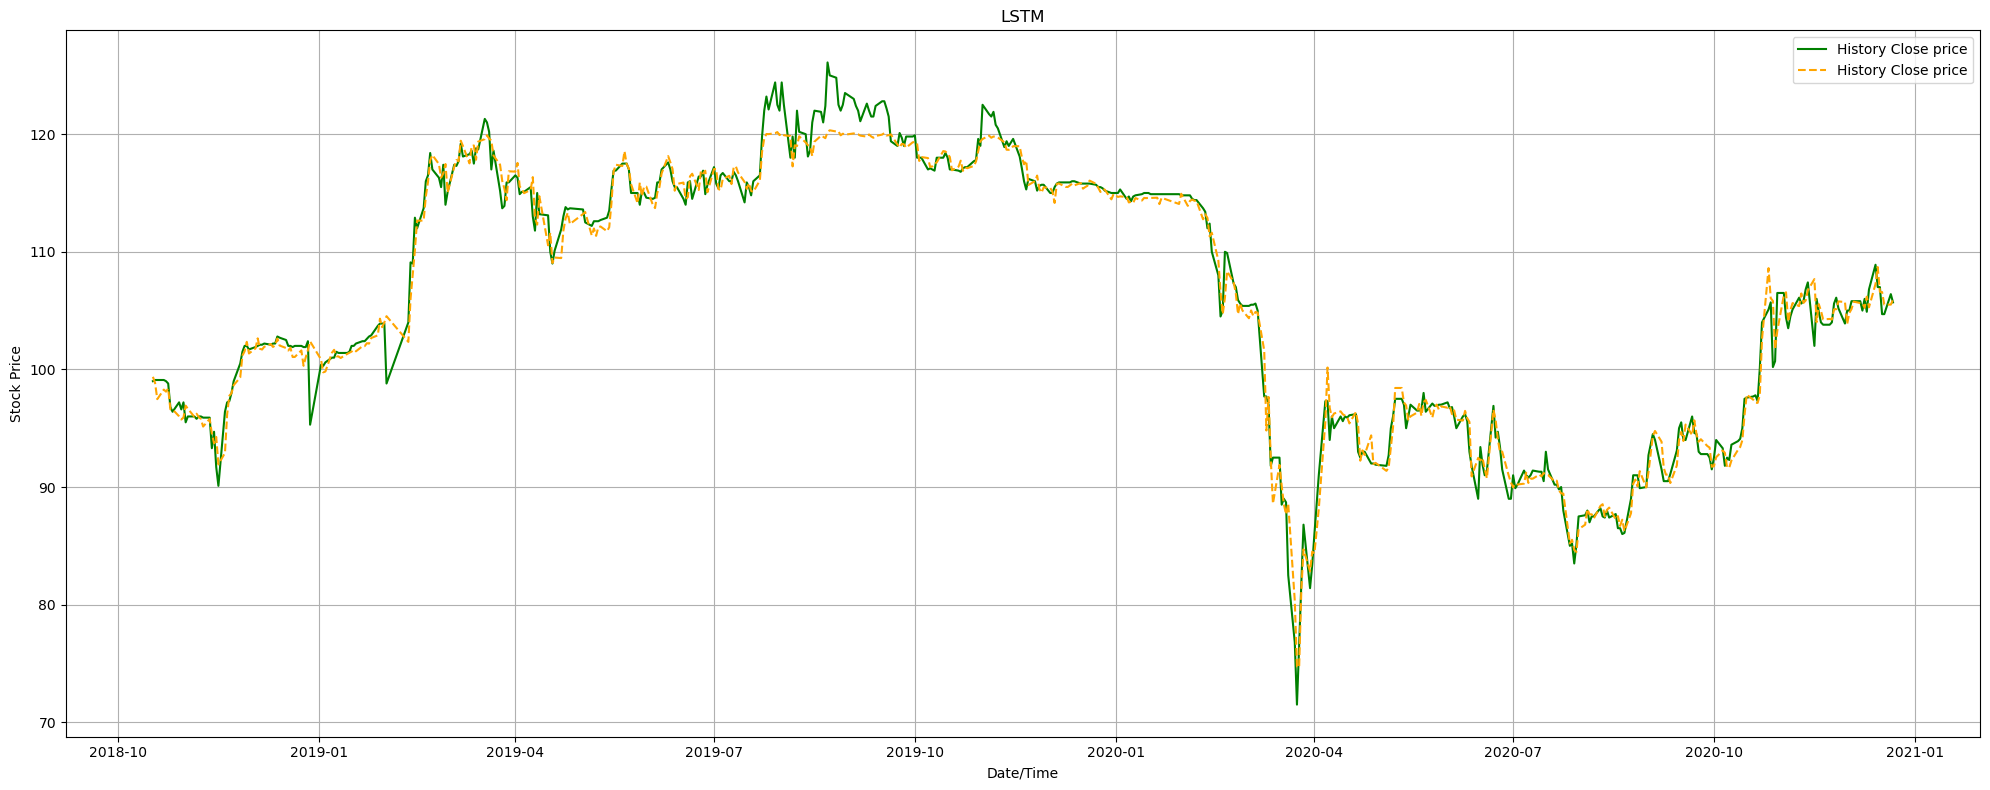

In [62]:
#Visualize results

models = ['Random Forest', 'Linear Regression', 'Support Vector Regression', 'LSTM']
close_predictions = ['Close_rf_pred', 'Close_lr_pred', 'Close_svr_pred', 'Close_lstm_pred']

for model, close_pre in zip(models, close_predictions):
    plt.figure(figsize=(20, 8))
    plt.plot(data['Date/Time'], data['Close'], label='History Close price', color='green')
    plt.plot(data['Date/Time'], data[close_pre], label='History Close price', color='orange', linestyle='dashed')
    plt.title(model)
    plt.xlabel('Date/Time')
    plt.ylabel('Stock Price')
    plt.tight_layout()
    plt.legend()
    plt.grid(True)
    plt.show()
